Este notebook contém um código que implementa a PINN do oscilador harmônico amortecido (OHA) 1D.

# **Descrição do problema**

Equação da dinâmica do OHA 1D é:

$$
m x'' + \mu x' + kx = 0~,
$$

onde $m$ é a massa do bloco, $k$ a constante da mola e $\mu$ o fator de amortecimento.

Condições iniciais:

$$
x(0) = 1~~,~~x'(0) = 0~.
$$

Vamos considerar o caso subamortecido:

$$
\delta < \omega_0~,~~~~~\mathrm{com}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$

Cuja solução exata é:

$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{onde}~~\omega=\sqrt{\omega_0^2 - \delta^2}~
$$

é a frequência de oscilação amortecida.

A ideia é primeiramente treinar uma rede neural padrão para interpolar uma pequena parte da solução, usando alguns dados de treino coletados da solução exata.

Vamos usar essa rede padrão como uma tentativa inicial de encontrar os melhores parâmetros para uma rede neural que forneça uma boa convergência para a solução exata já conhecida.

Logo, treinamos uma PINN para extrapolar a solução completa fora dos dados de treino, de modo que a equação diferencial subjacente reforça a Função Loss.



# **Configurações gerais**

In [1]:
# chama os módulos necessários

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from __future__ import division, print_function
import sys
from PIL import Image

In [2]:
# implementa a solução exata do OHA (caso subamortecido)

def oscillator(d, w0, t):
    assert d < w0

    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi + w*t)
    sin = torch.sin(phi + w*t)
    exp = torch.exp(-d*t)
    x  = exp*2*A*cos

    return x

Vamos configurar um MLP com uma camada de entrada, várias camadas ocultas e uma camada de saída. As camadas ocultas têm a mesma quantidade de neurônios (N_HIDDEN). A função de ativação em todas as camadas (exceto na camada de saída) é a tangente hiperbólica.

In [3]:
# configura a rede neural de conexão direta (multilayer perceptron)

class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS - 1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, t):
        t = self.fcs(t)
        t = self.fch(t)
        t = self.fce(t)
        return t

In [4]:
# mostra os gráficos das soluções exata e aproximada

def plot_result(t, x, t_data, x_data, x_pred, t_pred = None):

    plt.figure(figsize = (8,4))

    plt.plot(t, x_pred, color = "tab:red", linewidth = 2, alpha = 0.8, label = "Predição da rede neural")
    plt.plot(t, x, color = "blue", linewidth = 2, alpha = 0.8, linestyle = "--", label = "Solução exata")
    plt.scatter(t_data, x_data, s = 60, color = "tab:green", alpha = 0.4, label = "Dados de treino")
    if t_pred is not None:
        plt.scatter(t_pred, -0*torch.ones_like(t_pred), s = 40, color = "tab:purple", alpha = 0.4, label = "Pontos de colocação")
    l = plt.legend(loc = (1.02,0.4), frameon = False, fontsize = "large")
    plt.setp(l.get_texts(), color = "k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7, "Estágio: %i"%(i+1), fontsize = "xx-large", color = "k")
    plt.ylabel("$x(t)$", fontsize = "x-large")
    plt.xlabel("$t$", fontsize = "x-large")
    plt.axis("on")

# **Obtenção dos dados de treino a partir a solução exata**

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


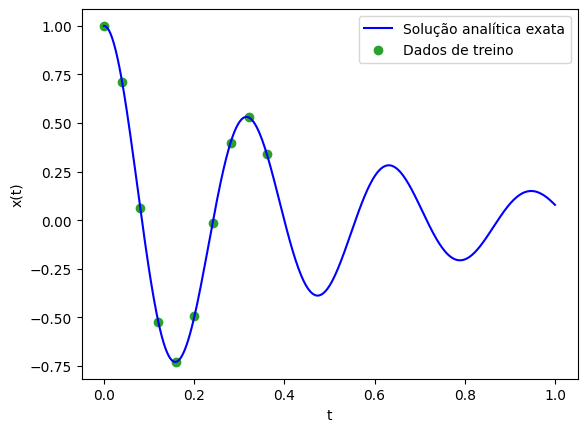

In [5]:
# configuração dos dados

d, w0 = 2, 20

# mostra a solução exata em todo o domínio

t = torch.linspace(0,1,500).view(-1,1)
x = oscillator(d, w0, t).view(-1,1)
print(t.shape, x.shape)

# coleta 10 dados da solução exata

t_data = t[0:200:20]
x_data = x[0:200:20]
print(t_data.shape, x_data.shape)

# condições de contorno

t_cc = t[0]
x_cc = x[0]

# grafica a solução exata e 10 dados de treino

plt.figure()
plt.plot(t, x, color = "blue", label = "Solução analítica exata")
plt.scatter(t_data, x_data, color = "tab:green", label = "Dados de treino")
plt.legend()
plt.ylabel("x(t)")
plt.xlabel("t")
plt.show()

# **Treino da rede neural padrão**

Vamos configurar um MLP com $1$ camada de entrada e de saída, ambas de tamanho $1$, $3$ camadas ocultas e $32$ neurônios em cada uma delas: $model = FCN(1, 1, 32, 3)$. O learning rate é da ordem de $10^{-4}$. Durante o treino, os parâmetros do modelo são otimizados com o otimizador $Adam$. A acurácia dos dados previstos é obtida calculando os $MSE$ (Mean Squared Error), $MAE$ (Mean Absolute Error) e fator $R^2$, medidos entre os dados de previsão e a solução exata.

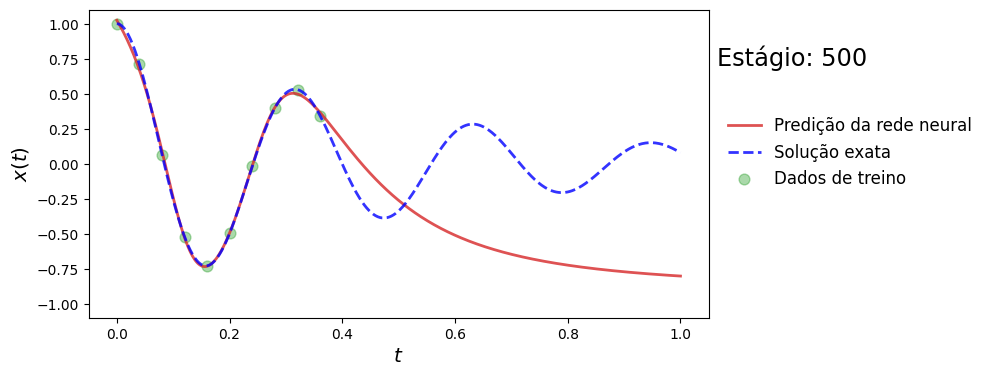

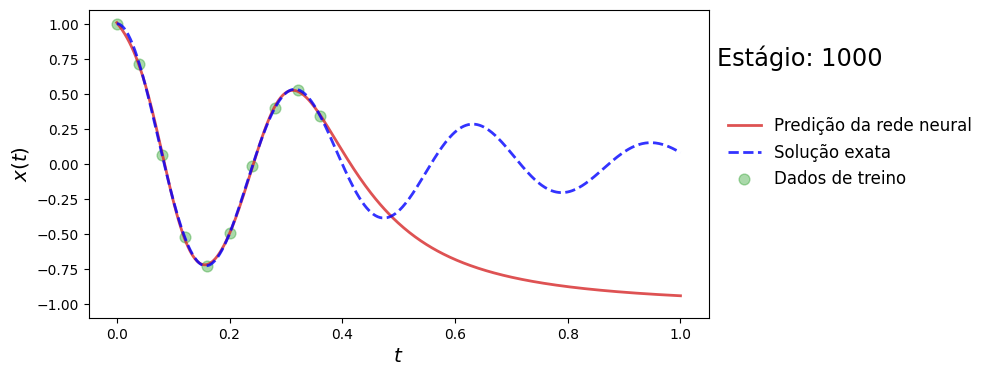

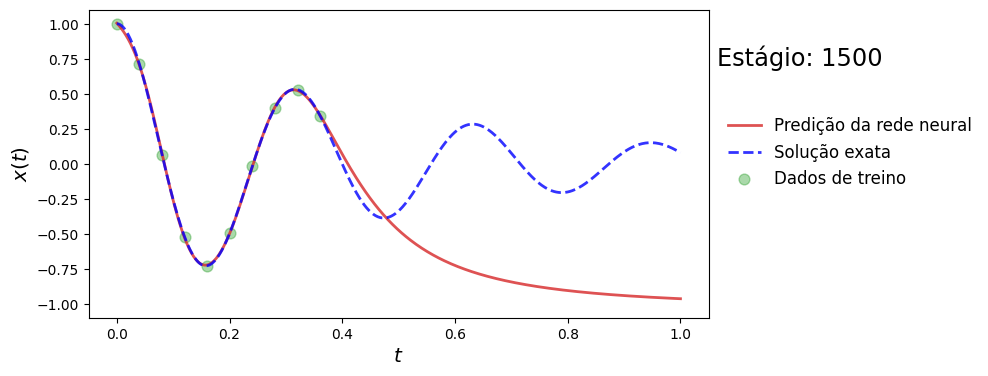

In [6]:
# treina a rede neural padrão para ajustar os dados de treino

torch.manual_seed(7)
model = FCN(1, 1, 32, 3)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
files = []

for i in range(1500):
    optimizer.zero_grad()
    x_pred = model(t_data)
    loss = torch.mean((x_pred - x_data)**2)  # erro quadrático médio
    loss.backward()
    optimizer.step()

    # grafica os resultados dos estágios do treino

    if (i+1) % 10 == 0:
        x_pred = model(t).detach()
        plot_result(t, x, t_data, x_data, x_pred, t_pred = None)
        if (i+1) % 500 == 0: plt.show()
        else: plt.close("all")

Como esperado, observe que a rede neural padrão não consegue fazer previsões da solução exata além dos dados de treino fornecidos.

# **Treino da PINN**

Agora vamos adicionar a equação diferencial (physics loss) à Função Loss. A physics loss visa garantir que a solução aprendida seja consistente com a equação diferencial subjacente. Fazemos isso penalizando o resíduo da equação diferencial sobre o conjunto de pontos amostrados no domínio (pontos de colocação).

Escolhemos $30$ pontos de colocação uniformemente espaçados no domínio do problema. Além disso, calculamos as derivadas da saída da rede (dados previstos) em relação à variável de entrada (pontos de colocação). Calculamos o resíduo da equação diferencial usando os recursos de autodiferenciação do Pytorch.

Os parâmetros do modelo são: $model = FCN(1, 1, 32, 3)$, o número de épocas: $20.000$ e diminuímos o learning rate para $10^{-4}$.

Neste trabalho somente utilizamos $10$ dados da solução exata para treinar uma PINN inicialmente, a modo de observar os resultados. Nas demais configurações e treinos da PINN utilizamos como dados de entrada somente a condição inicial e as EDOs para penalizar a rede.


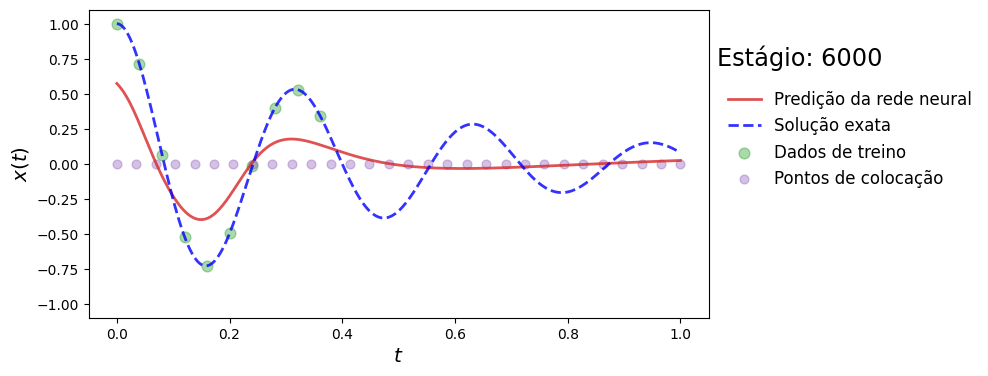

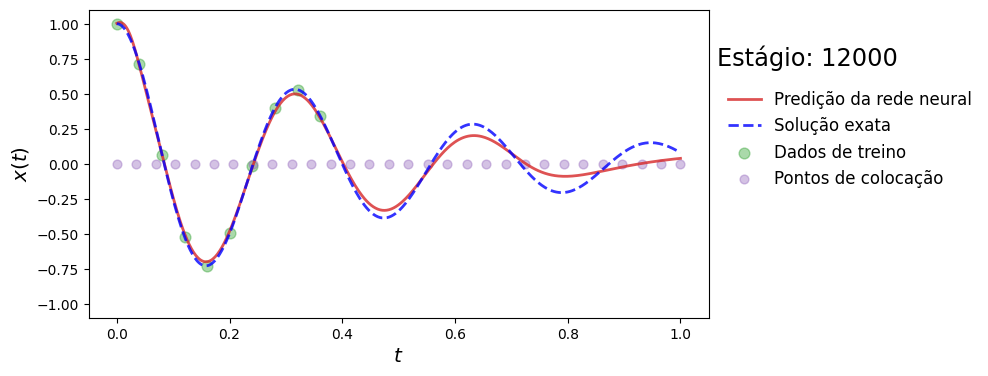

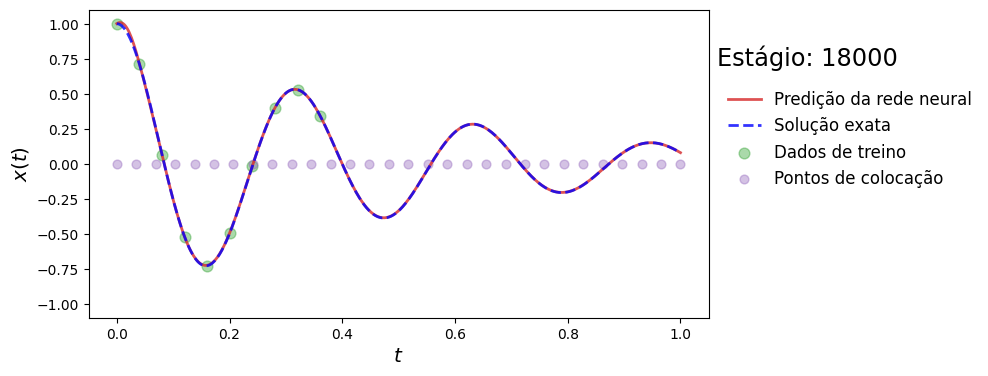

In [7]:
# determina o conjunto de pontos de colocação no domínio físico

t_physics = torch.linspace(0, 1, 30).view(-1,1).requires_grad_(True)
mu, k = 2*d, w0**2

# configuração do treino da PINN

torch.manual_seed(7)
model = FCN(1, 1, 32, 3)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
files = []
loss1_history = []
loss2_history = []
loss_history = []
mse_history = []
mae_history = []
r2_history = []

# loop de treino

for i in range(20000):
    optimizer.zero_grad()

    # calcula o "data loss"

    x_pred = model(t_data)
    loss1 = torch.mean((x_pred - x_data)**2)  # erro quadrático médio

    # calcula a "physics loss"

    x_pred_p = model(t_physics)

    # calcula o resíduo

    dt  = torch.autograd.grad(x_pred_p, t_physics, torch.ones_like(x_pred_p), create_graph = True)[0] # dy/dt
    dt2 = torch.autograd.grad(dt,  t_physics, torch.ones_like(dt),  create_graph = True)[0] # d^2y/dt^2
    physics = dt2 + mu*dt + k*x_pred_p

    loss2 = torch.mean(physics**2)

    # backpropagate da loss total

    loss = loss1 + (1e-4)*loss2
    loss.backward()
    optimizer.step()

    # grafica o resultado dos estágios do treino

    if (i+1) % 150 == 0:
        loss1_history.append(loss1.detach())
        loss2_history.append(loss2.detach())
        loss_history.append(loss.detach())

        x_pred = model(t).detach()
        t_pred = t_physics.detach()

        x_pred_p = model(t)

        mse = torch.mean((x_pred_p - x)**2)  # erro quadrático médio
        mse_history.append(mse.detach())

        mae = torch.mean(torch.abs(x_pred_p - x))  # erro absoluto médio
        mae_history.append(mae.detach())

        res = torch.sum((x_pred_p - x)**2)
        tot = torch.sum((torch.mean(x) - x)**2)
        r2 = 1 - res/tot                    # fator R^2
        r2_history.append(r2.detach())

        plot_result(t, x, t_data, x_data, x_pred, t_pred)

        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")

Observe que no final do treino a rede neural obteve uma solução aproximada que sobrepôs muito bem a solução exata conhecida.

Para testar a acurácia do modelo vamos analisar as métricas $MSE$, $MAE$ e o fator $R^2$ comparados com a evolução da Função Loss.

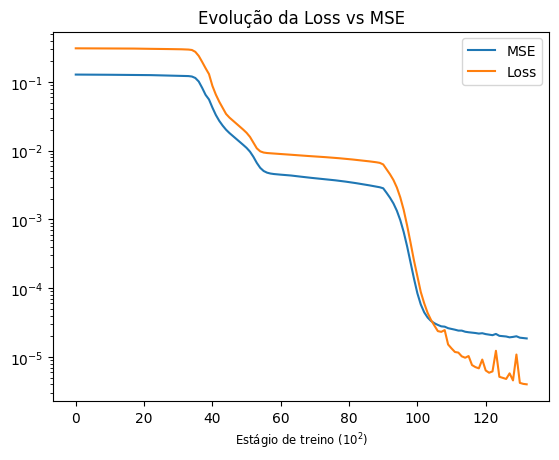

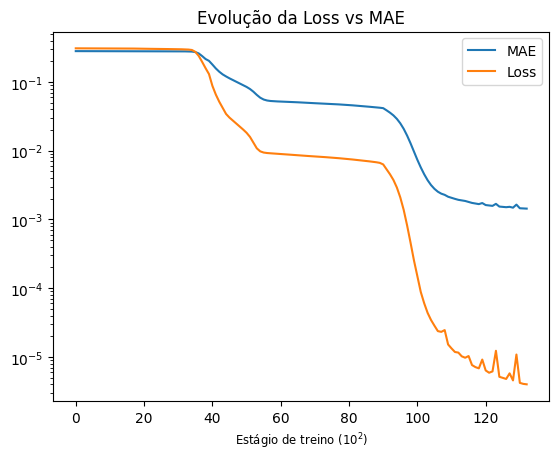

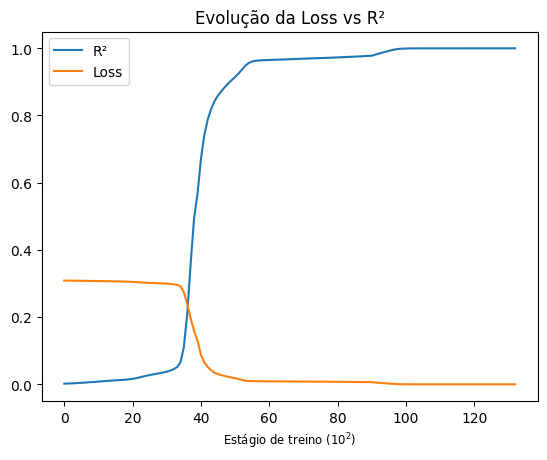

In [8]:
fig1 = plt.figure(1)
plt.plot(mse_history, label = "MSE")
plt.plot(loss_history, label = "Loss")
plt.title("Evolução da Loss vs MSE")
plt.xlabel("Estágio de treino ($10^2$)", fontsize = "small")
plt.yscale("log")
plt.legend()

fig2 = plt.figure(2)
plt.plot(mae_history, label = "MAE")
plt.plot(loss_history, label = "Loss")
plt.title("Evolução da Loss vs MAE")
plt.xlabel("Estágio de treino ($10^2$)", fontsize = "small")
plt.yscale("log")
plt.legend()

fig3 = plt.figure(3)
plt.plot(r2_history, label = "R²")
plt.plot(loss_history, label = "Loss")
plt.title("Evolução da Loss vs R²")
plt.xlabel("Estágio de treino ($10^2$)", fontsize = "small")
plt.legend()

Note que o fator $R^2$ tende a $1$ à medida que a Loss tende a $0$, logo, a regressão é muito boa. Isso também é notado quando constatamos que a precisão da solução encontrada é da ordem de $10^{-4}$ para o $MSE$ e $10^{-3}$ para o $MAE$.

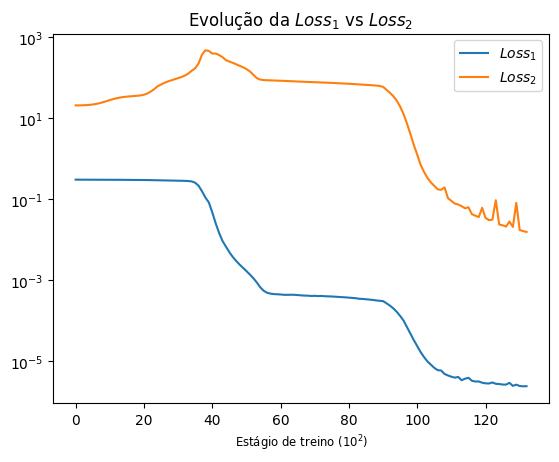

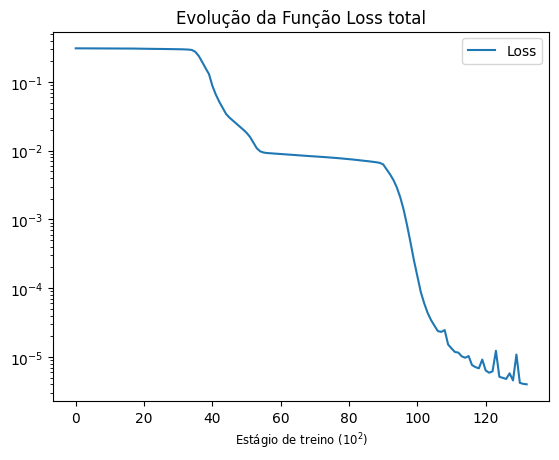

In [9]:
fig4 = plt.figure(4)
plt.plot(loss1_history, label = "$Loss_1$")
plt.plot(loss2_history, label = "$Loss_2$")
plt.title("Evolução da $Loss_1$ vs $Loss_2$")
plt.xlabel("Estágio de treino ($10^2$)", fontsize = "small")
plt.yscale("log")
plt.legend()

fig5 = plt.figure(5)
plt.plot(loss_history, label = "Loss")
plt.title("Evolução da Função Loss total")
plt.xlabel("Estágio de treino ($10^2$)", fontsize = "small")
plt.yscale("log")
plt.legend()

O decaimento da Função Loss à medida que o número de épocas aumenta demonstra que o modelo está corretamente configurado, no sentido de que está sendo alcançada a minimização da Loss.

Observe que a Função Loss$_{1}$ tem um peso maior durante o treino da rede neural. De fato, a rede sempre vai querer minimizar a Loss$_{1}$ satisfazendo os pontos conhecidos da solução exata. Já o peso da Função Loss$_{2}$ é pequeno.  Testamos para o caso da Loss$_2$ ter um peso maior que a Loss$_{1}$ e o modelo não convergiu para a solução exata, os resultados foram muito ruins.

O que a rede neural faz é procurar a melhor configuração que minimiza a Loss$_{2}$ e que satisfaz a equação diferencial, porém, dando um peso maior à Loss$_{1}$ e obtendo a solução da EDO que passa pelos pontos fornecidos da solução exata.


# **Treino da PINN somente com as condições de contorno**

Agora vamos testar o treino da rede neural considerando apenas a condição de contorno no data loss como único dado fornecido. A melhor configuração que achamos para obter a convergência da solução da EDO foi alterarmos os parâmetros do modelo inicial para: $model = FCN(1, 1, 42, 4)$, também aumentamos o número de épocas.

**Caso:** Loss$_{2}$ com peso 1e-4

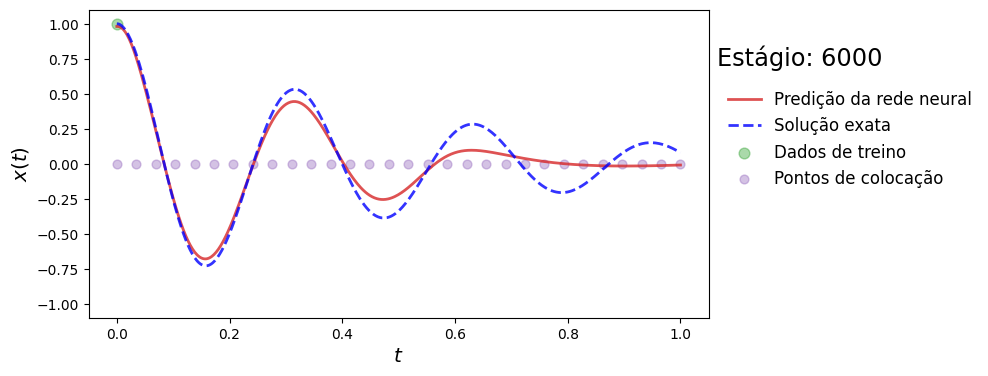

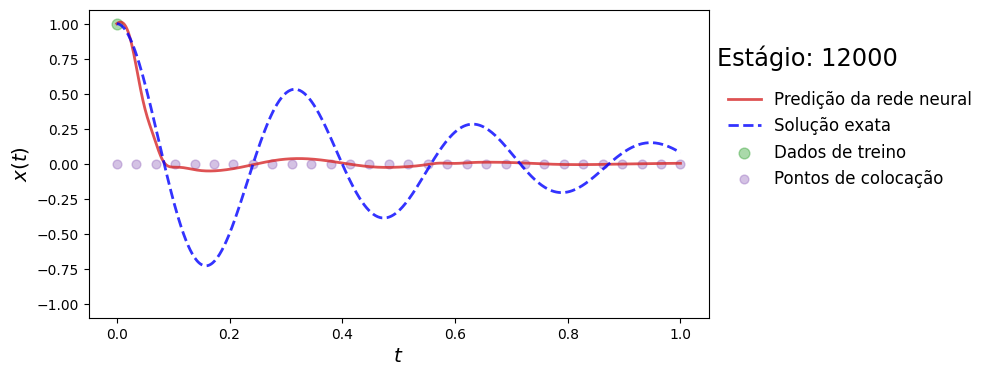

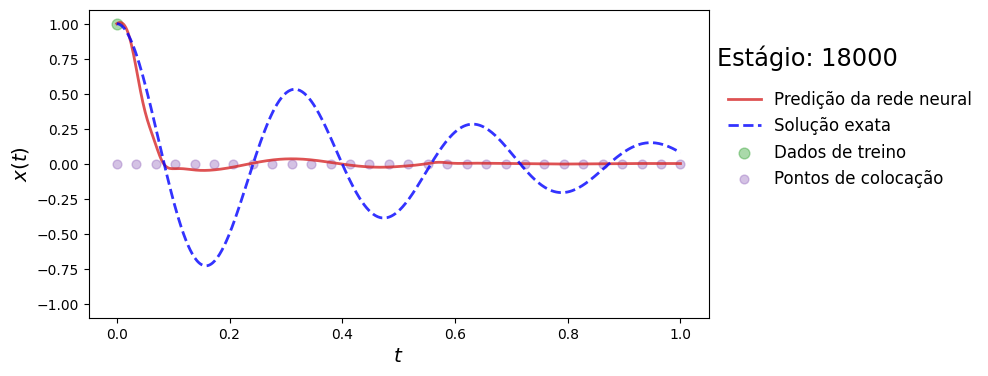

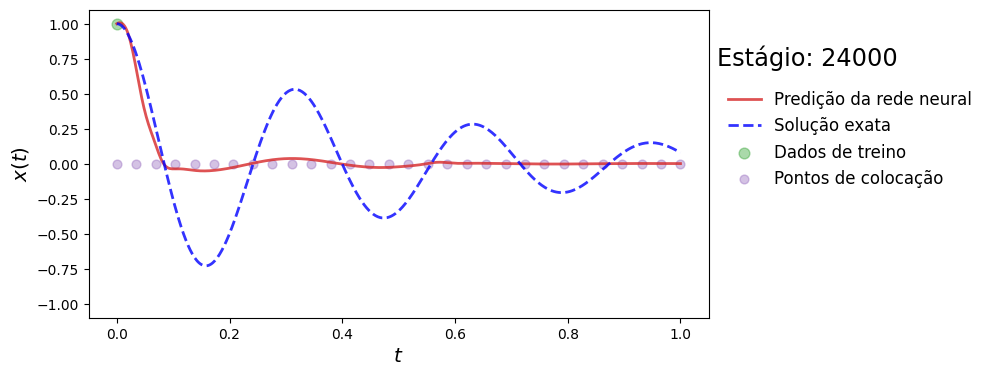

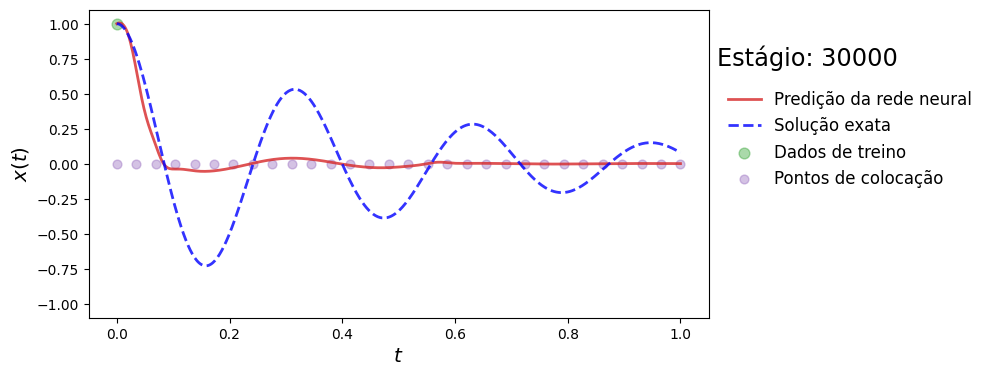

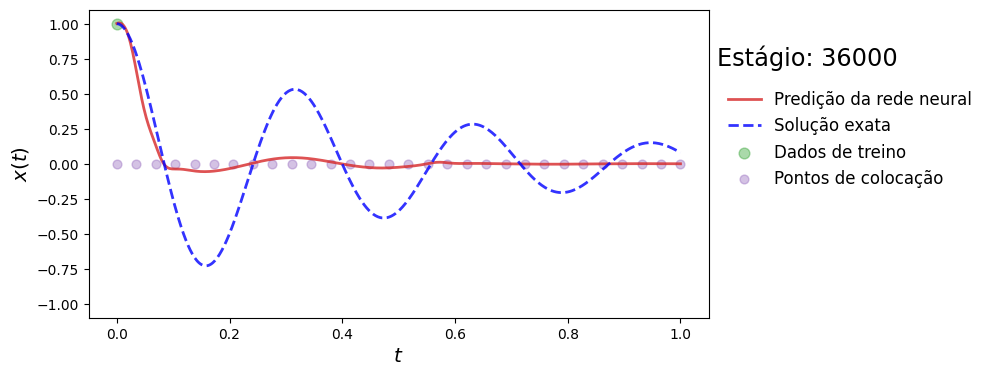

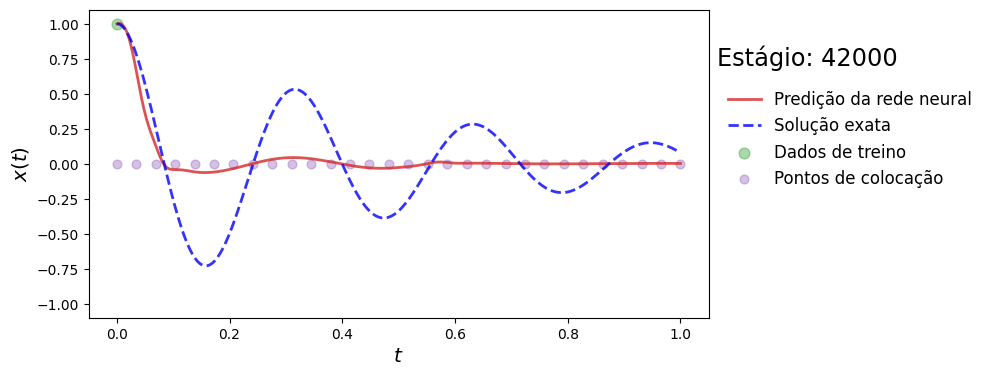

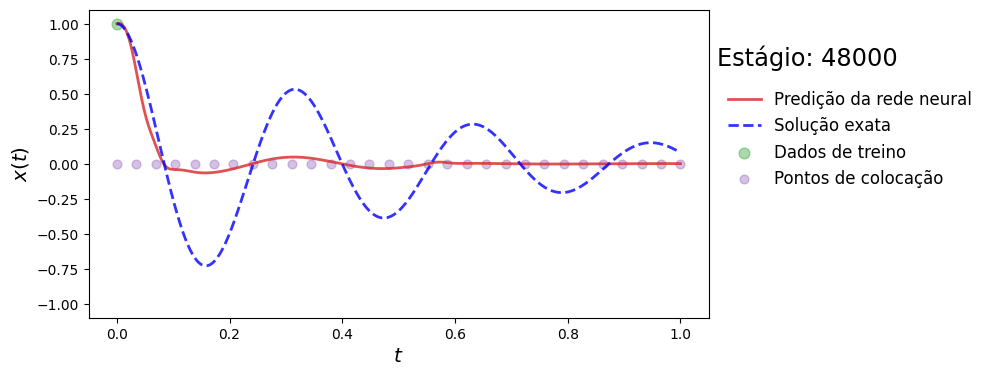

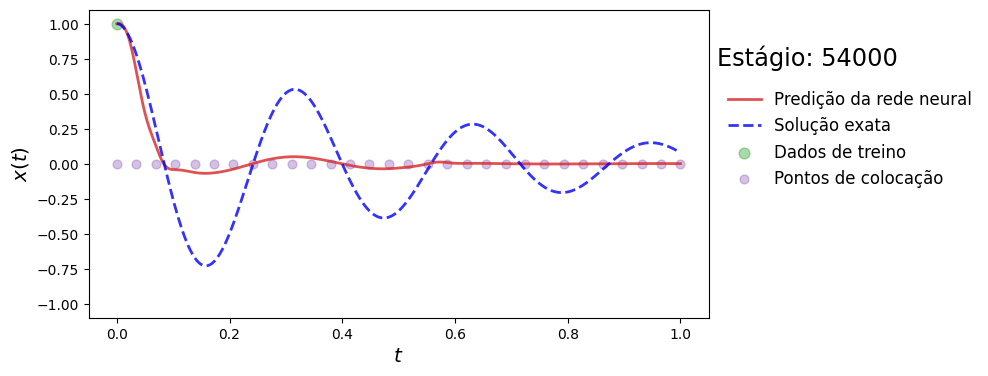

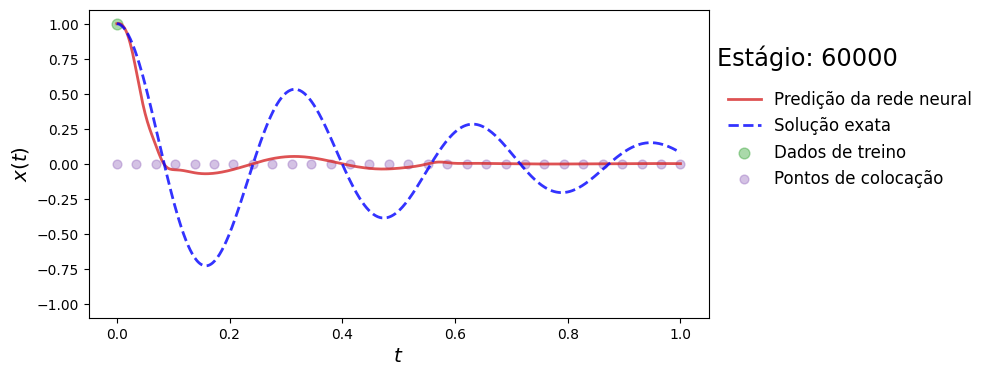

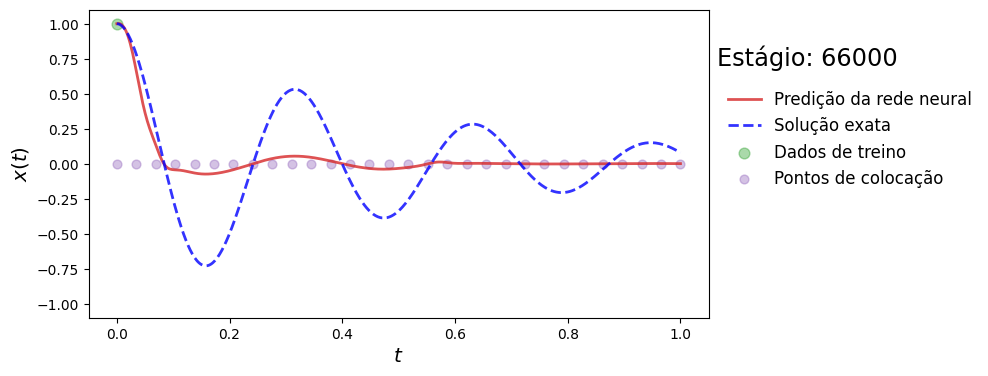

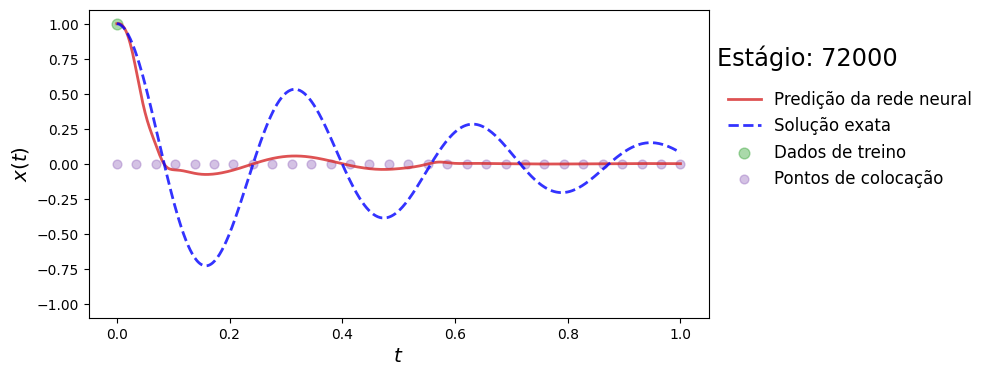

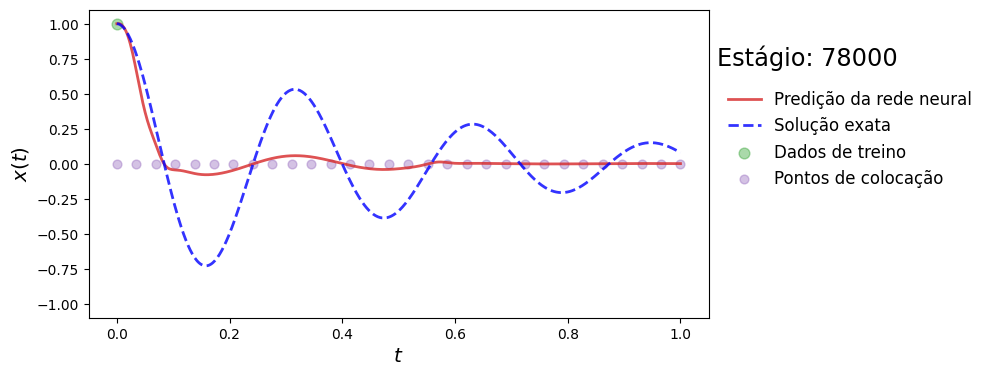

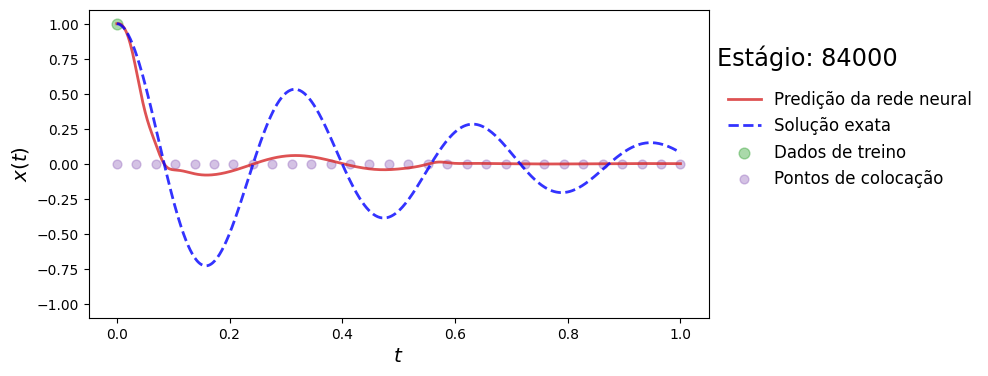

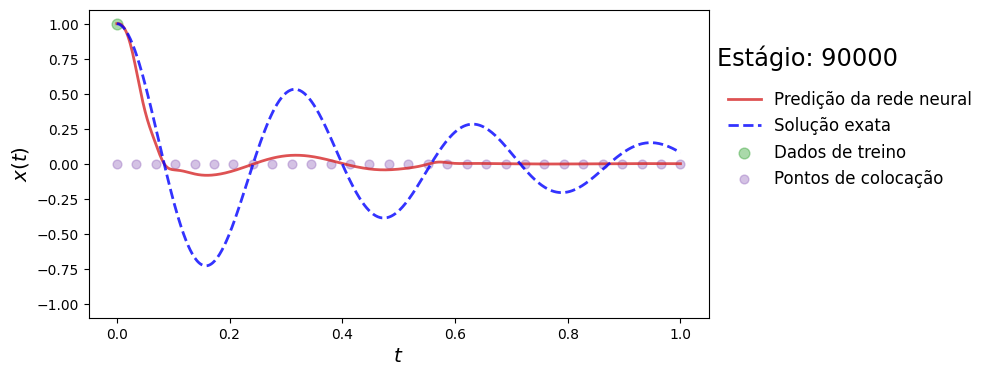

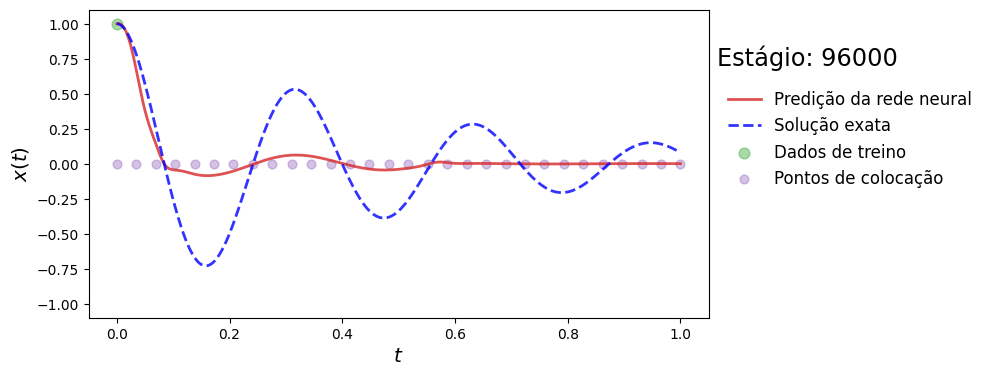

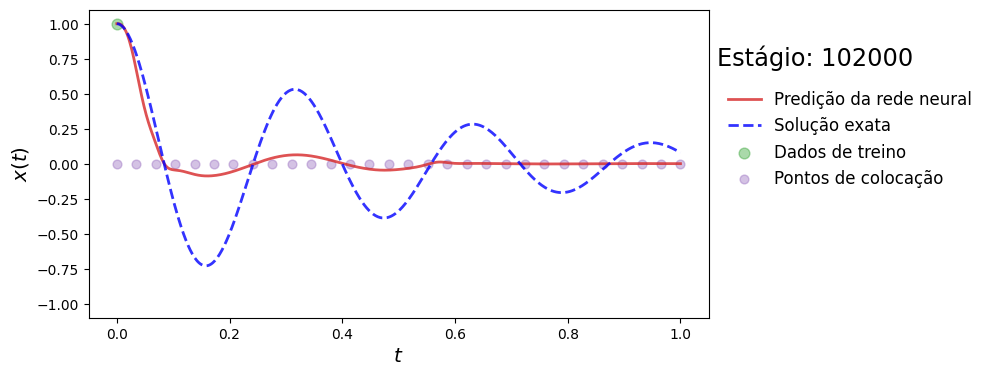

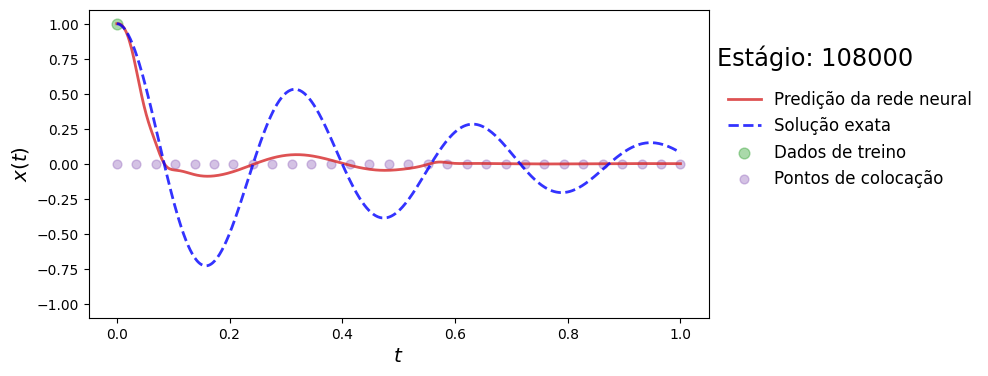

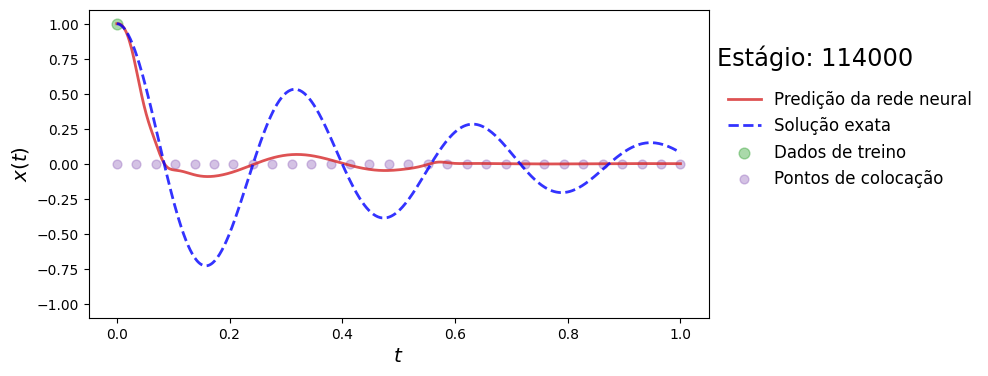

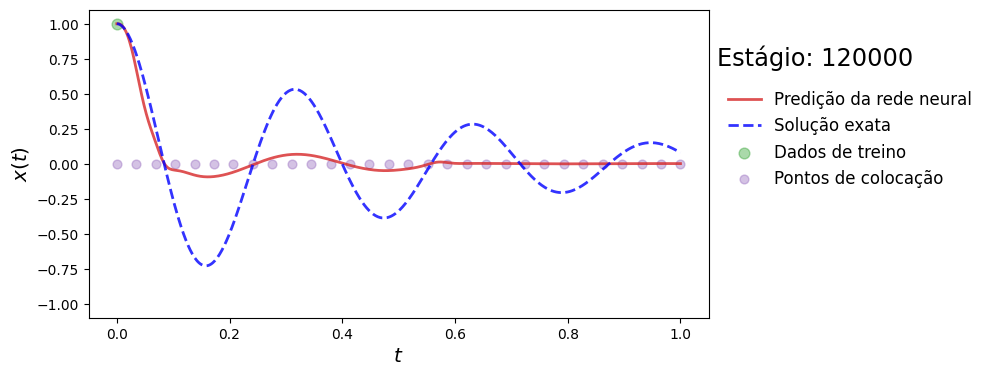

In [10]:
# determina o conjunto de pontos de colocação no domínio físico

t_physics_cc = torch.linspace(0, 1, 30).view(-1,1).requires_grad_(True)
mu, k = 2*d, w0**2

# configuração do treino da PINN

torch.manual_seed(7)
model = FCN(1, 1, 42, 4)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
files = []
loss1_cc_history = []
loss2_cc_history = []
loss_cc_history = []
mse_cc_history = []
mae_cc_history = []
r2_cc_history = []

# loop de treino

for i in range(120000):
    optimizer.zero_grad()

    # calcula o "data loss"

    x_pred_cc = model(t_cc)
    loss1_cc = torch.mean((x_pred_cc - x_cc)**2)  # erro quadrático médio

    # calcula a "physics loss"

    x_pred_p_cc = model(t_physics_cc)

    # calcula o resíduo

    dt_cc  = torch.autograd.grad(x_pred_p_cc, t_physics_cc, torch.ones_like(x_pred_p_cc), create_graph = True)[0] # dy/dt
    dt2_cc = torch.autograd.grad(dt_cc,  t_physics_cc, torch.ones_like(dt_cc),  create_graph = True)[0] # d^2y/dt^2
    physics_cc = dt2_cc + mu*dt_cc + k*x_pred_p_cc

    loss2_cc = torch.mean(physics_cc**2)

    # backpropagate joint loss

    loss_cc = loss1_cc + (1e-4)*loss2_cc
    loss_cc.backward()
    optimizer.step()

    # grafica o resultado dos estágios do treino

    if (i+1) % 150 == 0:
        loss1_cc_history.append(loss1_cc.detach())
        loss2_cc_history.append(loss2_cc.detach())
        loss_cc_history.append(loss_cc.detach())

        x_pred_cc = model(t).detach()
        t_pred_cc = t_physics_cc.detach()

        x_pred_p_cc = model(t)

        mse_cc = torch.mean((x_pred_p_cc - x)**2)  # erro quadrático médio
        mse_cc_history.append(mse_cc.detach())

        mae_cc = torch.mean(torch.abs(x_pred_p_cc - x))  # erro absoluto médio
        mae_cc_history.append(mae_cc.detach())

        res_cc = torch.sum((x_pred_p_cc - x)**2)
        tot_cc = torch.sum((torch.mean(x) - x)**2)
        r2_cc = 1 - res_cc/tot_cc                    # fator R^2
        r2_cc_history.append(r2_cc.detach())

        plot_result(t, x, t_cc, x_cc, x_pred_cc, t_pred_cc)

        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")

Observe que dando um peso de $10^{-4}$ à Loss${_2}$, o modelo não converge para a solução exata mesmo aumentando o número de épocas.

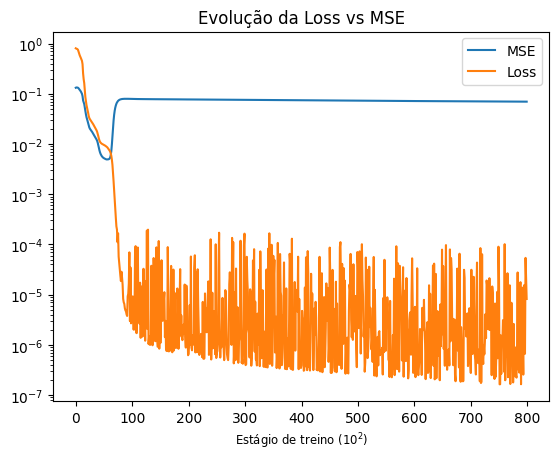

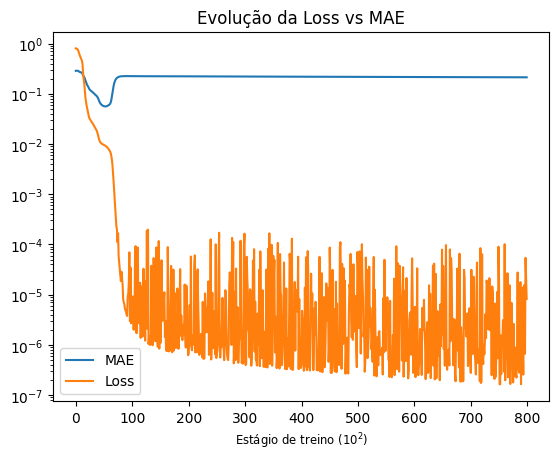

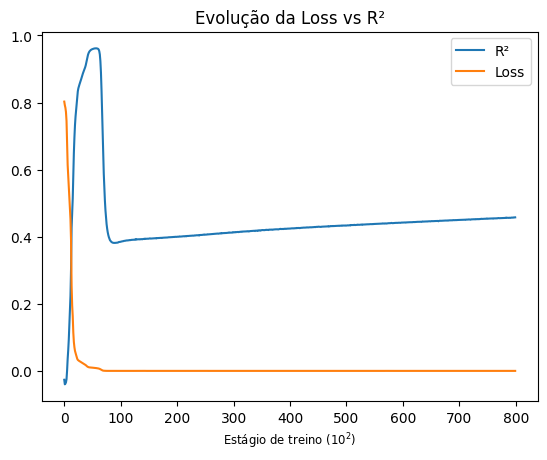

In [11]:
fig6 = plt.figure(6)
plt.plot(mse_cc_history, label = "MSE")
plt.plot(loss_cc_history, label = "Loss")
plt.title("Evolução da Loss vs MSE")
plt.xlabel("Estágio de treino ($10^2$)", fontsize = "small")
plt.yscale("log")
plt.legend()

fig7 = plt.figure(7)
plt.plot(mae_cc_history, label = "MAE")
plt.plot(loss_cc_history, label = "Loss")
plt.title("Evolução da Loss vs MAE")
plt.xlabel("Estágio de treino ($10^2$)", fontsize = "small")
plt.yscale("log")
plt.legend()

fig8 = plt.figure(8)
plt.plot(r2_cc_history, label = "R²")
plt.plot(loss_cc_history, label = "Loss")
plt.title("Evolução da Loss vs R²")
plt.xlabel("Estágio de treino ($10^2$)", fontsize = "small")
plt.legend()

Mesmo com a minimização da Função Loss as métricas associadas ao modelo não são boas e mostram que não há convergência do modelo para a solução exata. Isso fica evidente quando notamos que o fator $R^2$ tende a $0.4$ e a precisão da solução encontrada é da ordem de $0.1$.

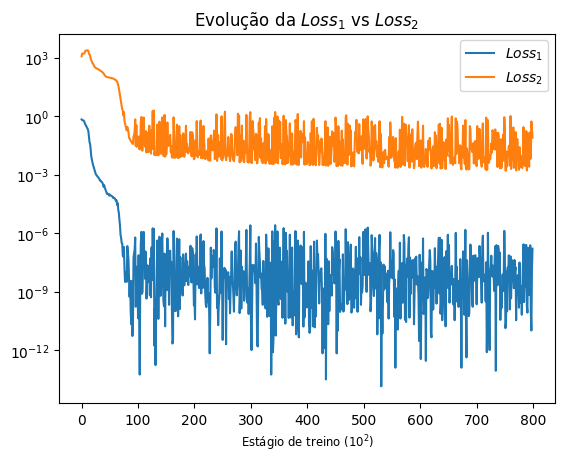

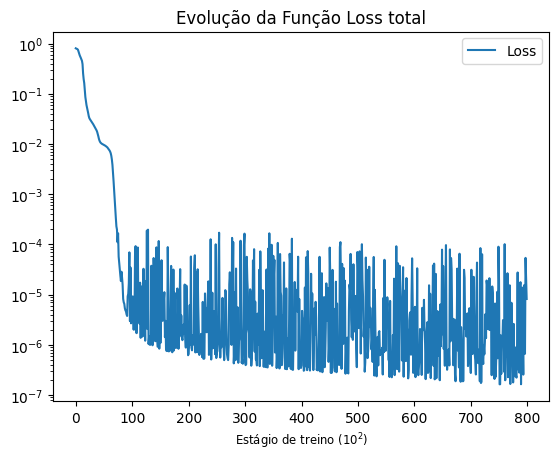

In [12]:
fig9 = plt.figure(9)
plt.plot(loss1_cc_history, label = "$Loss_1$")
plt.plot(loss2_cc_history, label = "$Loss_2$")
plt.title("Evolução da $Loss_1$ vs $Loss_2$")
plt.xlabel("Estágio de treino ($10^2$)", fontsize = "small")
plt.yscale("log")
plt.legend()

fig10 = plt.figure(10)
plt.plot(loss_cc_history, label = "Loss")
plt.title("Evolução da Função Loss total")
plt.xlabel("Estágio de treino ($10^2$)", fontsize = "small")
plt.yscale("log")
plt.legend()

O comportamento oscilatório da Função Loss implica que o tempo todo a rede está tentando calcular a melhor configuração que minimiza a Loss, porém, a rede retorna constantemente aos parâmetros anteriores e recomeça os cálculos tentando achar a melhor configuração. Ainda assim, observamos no gráfigo o decaimento da Loss.

**Caso:** Loss$_{2}$ com peso 1e-3

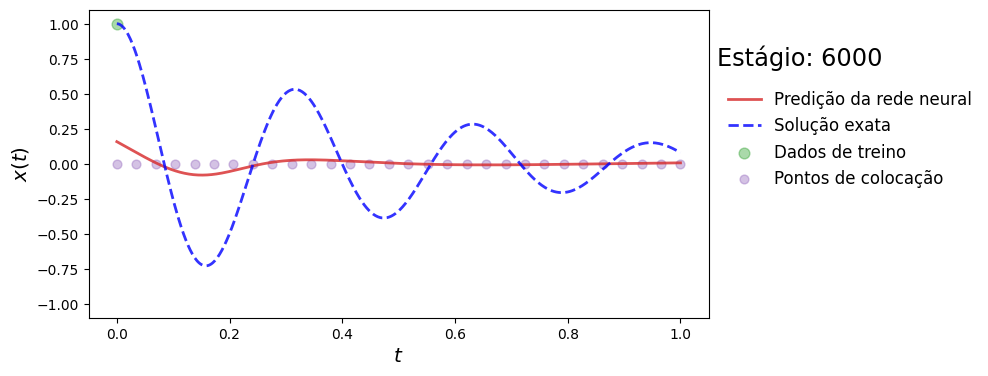

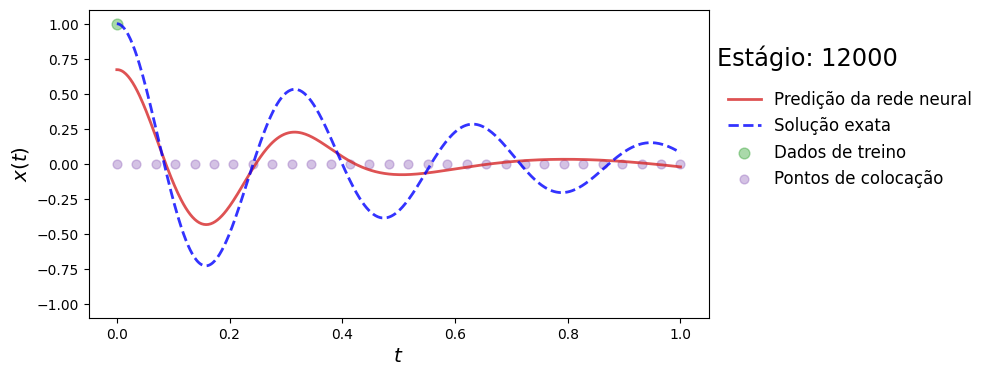

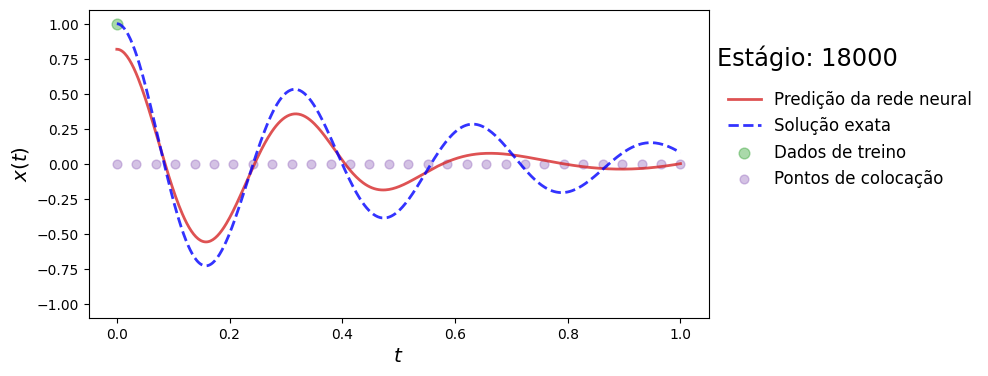

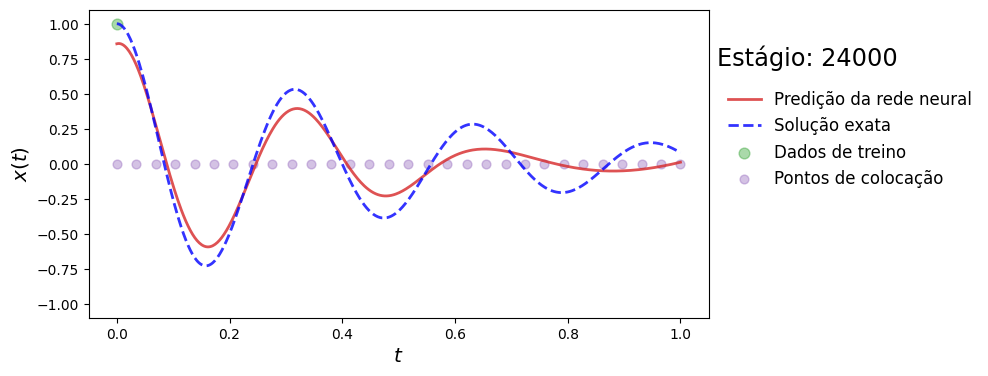

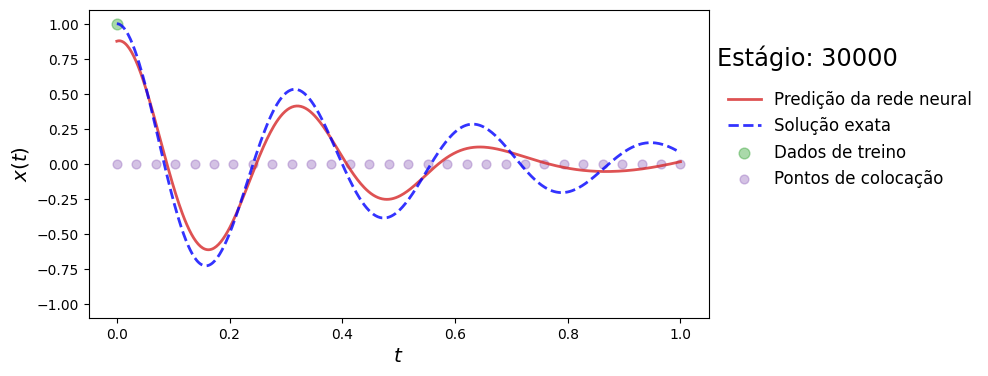

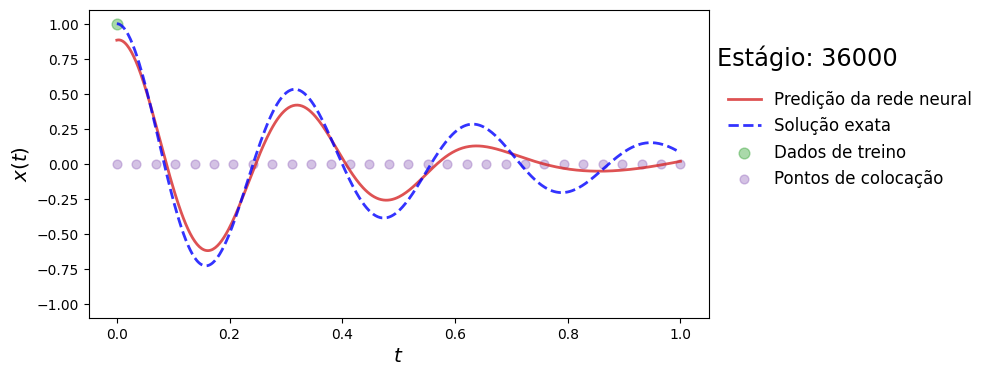

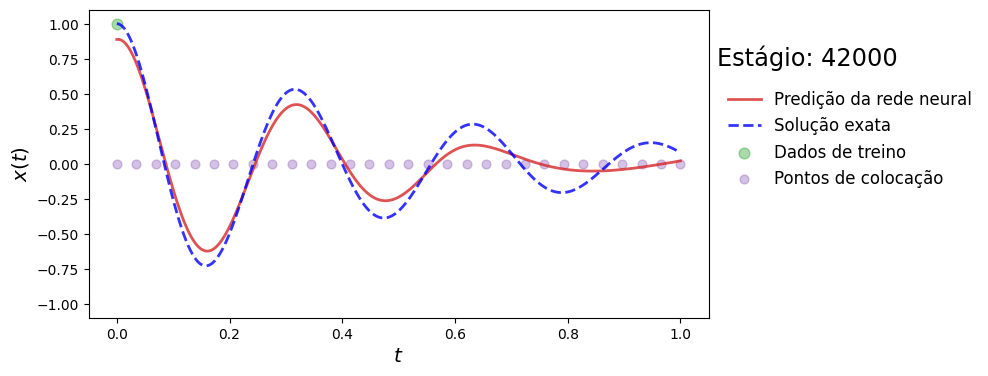

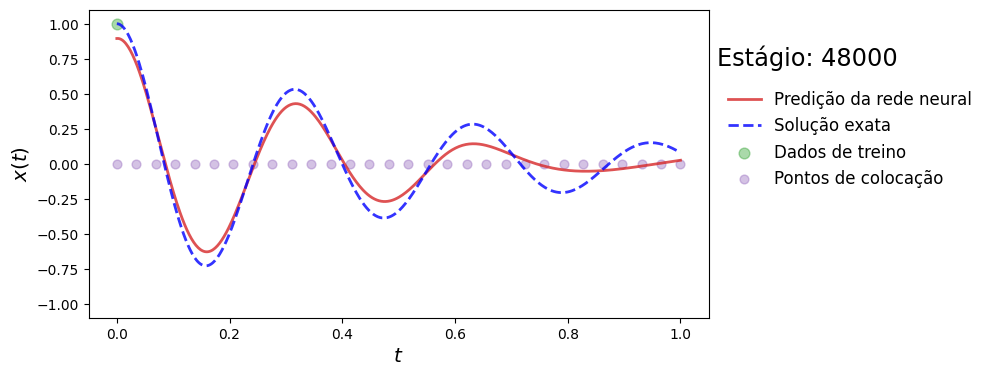

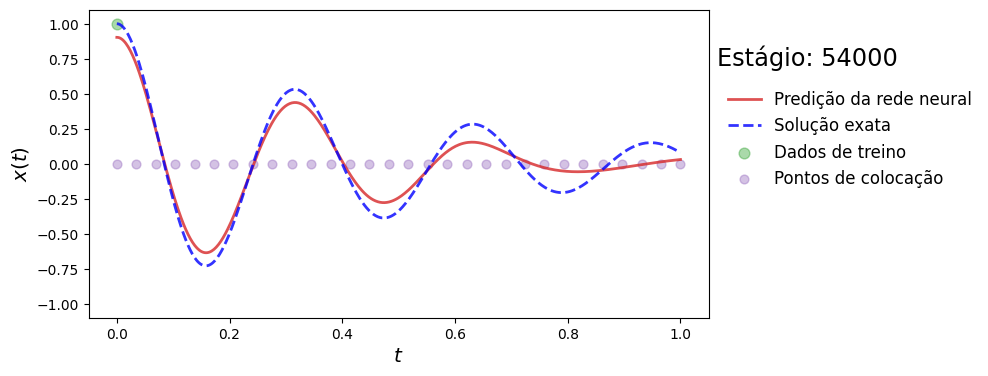

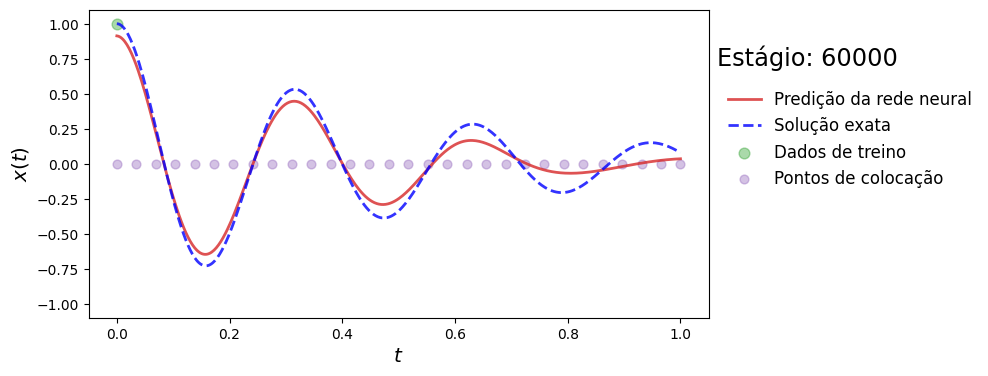

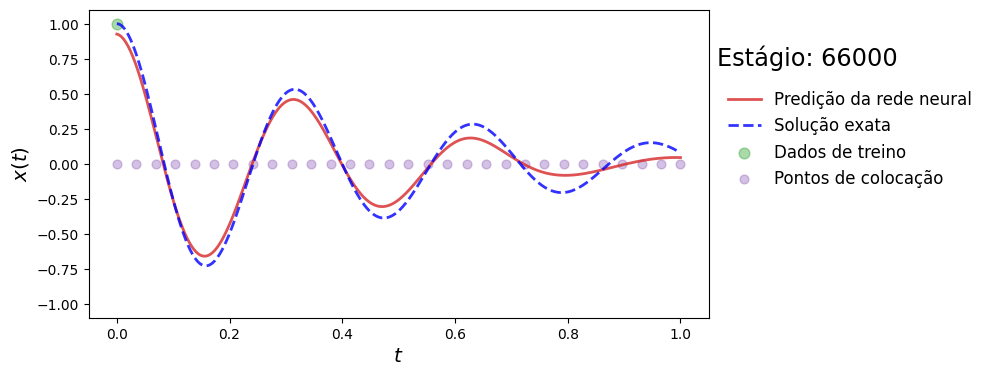

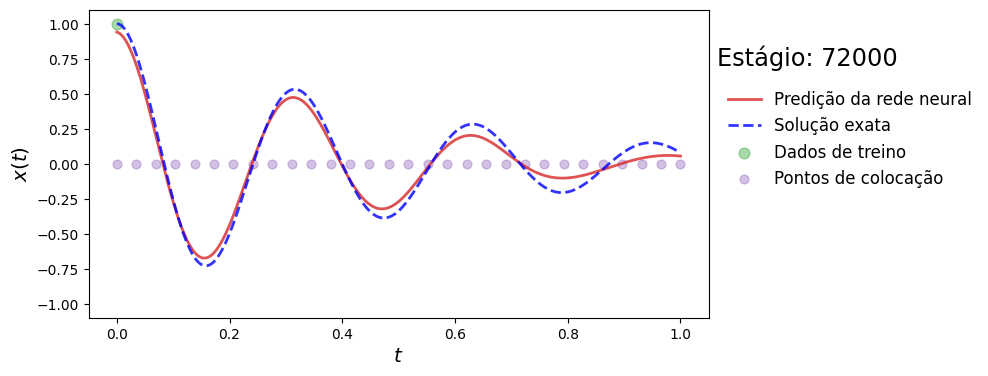

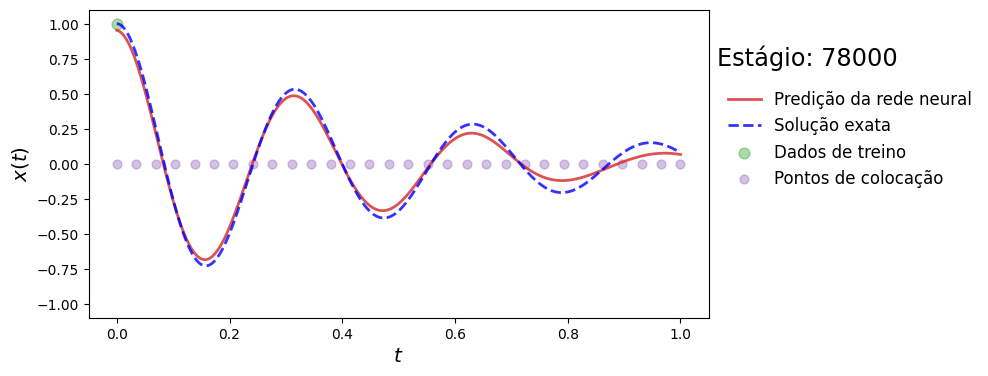

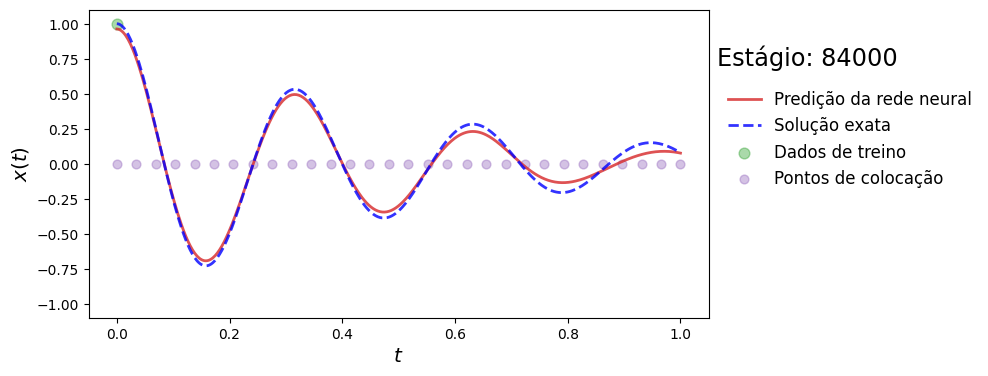

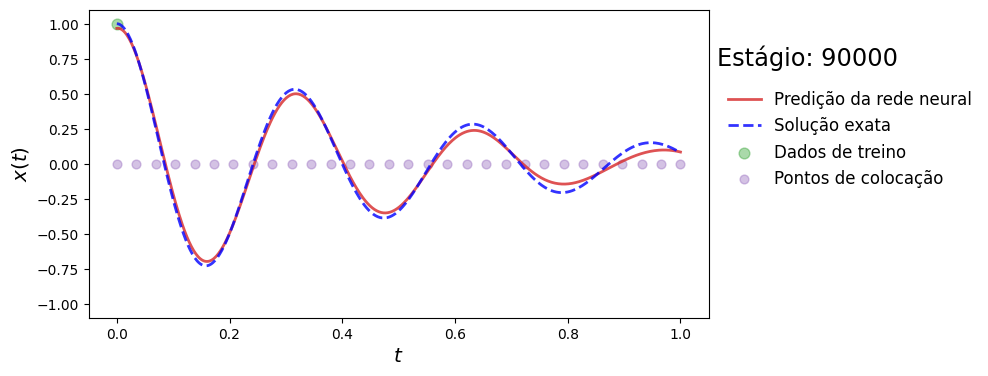

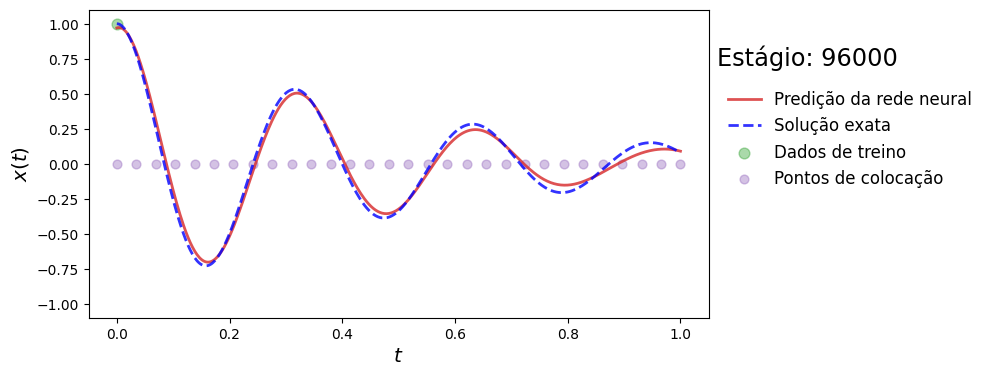

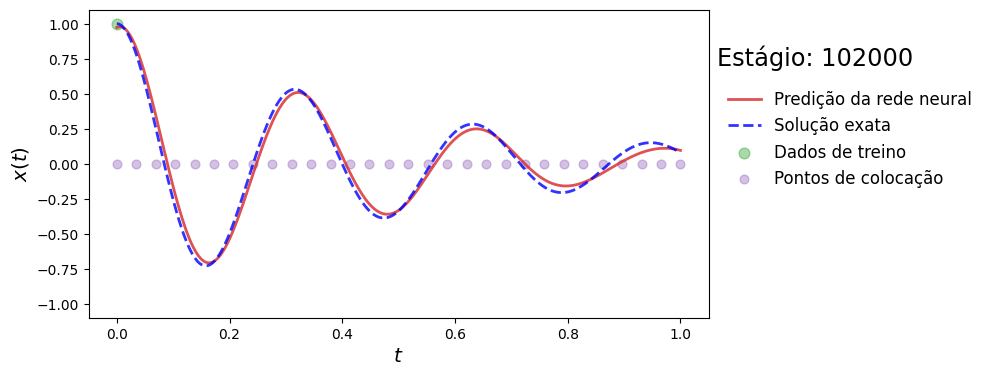

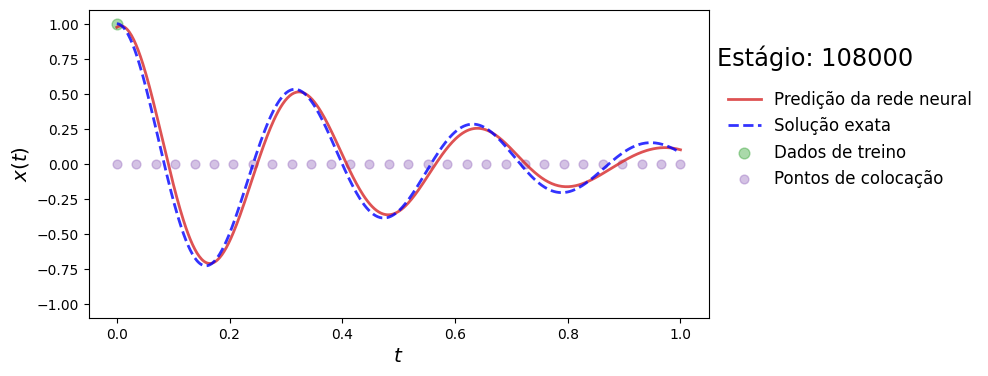

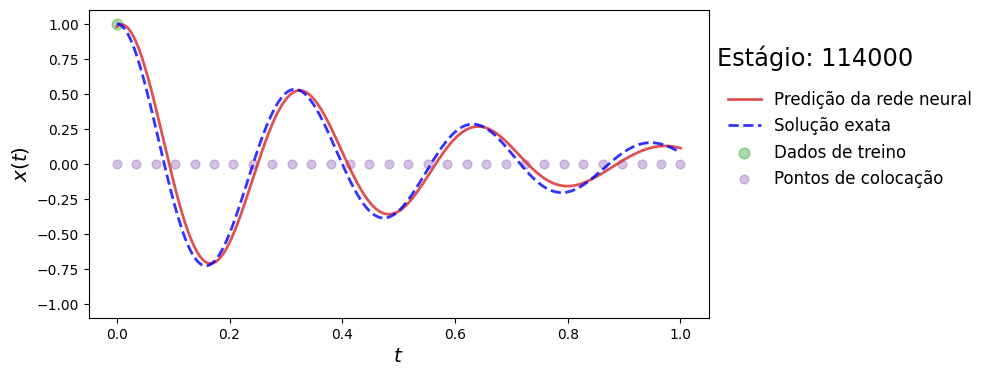

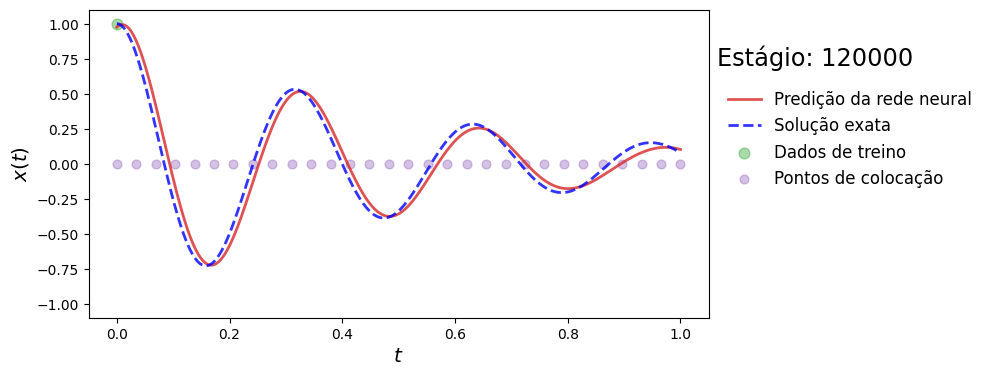

In [13]:
# determina o conjunto de pontos de colocação no domínio físico

t_physics_cc = torch.linspace(0, 1, 30).view(-1,1).requires_grad_(True)
mu, k = 2*d, w0**2

# configuração do treino da PINN

torch.manual_seed(7)
model = FCN(1, 1, 42, 4)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
files = []
loss1_cc_history = []
loss2_cc_history = []
loss_cc_history = []
mse_cc_history = []
mae_cc_history = []
r2_cc_history = []

# loop de treino

for i in range(120000):
    optimizer.zero_grad()

    # calcula o "data loss"

    x_pred_cc = model(t_cc)
    loss1_cc = torch.mean((x_pred_cc - x_cc)**2)

    # calcula a "physics loss"

    x_pred_p_cc = model(t_physics_cc)

    # calcula o resíduo

    dt_cc  = torch.autograd.grad(x_pred_p_cc, t_physics_cc, torch.ones_like(x_pred_p_cc), create_graph = True)[0] # dy/dt
    dt2_cc = torch.autograd.grad(dt_cc,  t_physics_cc, torch.ones_like(dt_cc),  create_graph = True)[0] # d^2y/dt^2
    physics_cc = dt2_cc + mu*dt_cc + k*x_pred_p_cc

    loss2_cc = torch.mean(physics_cc**2)

    # backpropagate joint loss

    loss_cc = loss1_cc + (1e-3)*loss2_cc
    loss_cc.backward()
    optimizer.step()

    # grafica o resultado dos estágios do treino

    if (i+1) % 150 == 0:
        loss1_cc_history.append(loss1_cc.detach())
        loss2_cc_history.append(loss2_cc.detach())
        loss_cc_history.append(loss_cc.detach())

        x_pred_cc = model(t).detach()
        t_pred_cc = t_physics_cc.detach()

        x_pred_p_cc = model(t)

        mse_cc = torch.mean((x_pred_p_cc - x)**2)  # erro quadrático médio
        mse_cc_history.append(mse_cc.detach())

        mae_cc = torch.mean(torch.abs(x_pred_p_cc - x))  # erro absoluto médio
        mae_cc_history.append(mae_cc.detach())

        res_cc = torch.sum((x_pred_p_cc - x)**2)
        tot_cc = torch.sum((torch.mean(x) - x)**2)
        r2_cc = 1 - res_cc/tot_cc                    # fator R^2
        r2_cc_history.append(r2_cc.detach())

        plot_result(t, x, t_cc, x_cc, x_pred_cc, t_pred_cc)

        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")

Estes foram os parâmetros do modelo que melhor convergem para a solução exata. Observe que no final do treino há um pequeno delay entre a solução exata e a solução obtida pela rede neural. Isso é consequência direta dos diferentes pesos das Loss$_{1}$ e Loss$_{2}$, como uma "disputa" direta entre encontrar uma solução que satisfaz a condição de contorno (expressa na Loss$_{1}$) e uma solução que satisfaz a equação diferencial (expressa na Loss$_{2}$).

Um dos fatores que podem ter contribuído para esse pequeno delay é o espaçamento entre os pontos de colocação (que são os dados de entrada da rede neural) e a condição de contorno ser o único dado de treino, tanto que, para o caso em que treinamos a rede com $10$ dados obtidos da solução exata o modelo converge muito bem. Além disso, como já mencionado, também tem influência os diferentes pesos dados às Loss$_{1}$ e Loss$_{2}$

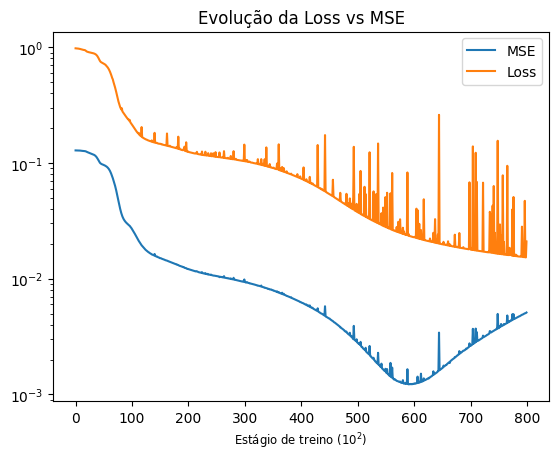

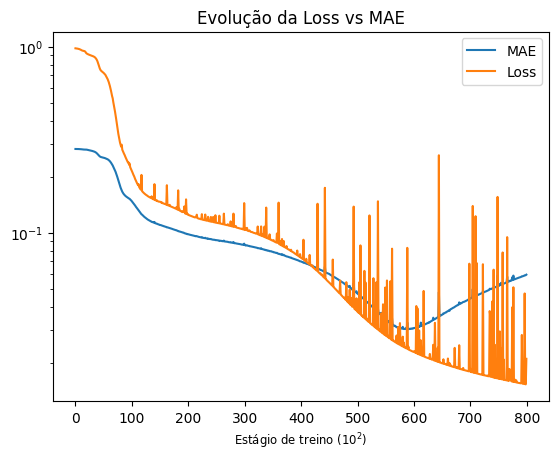

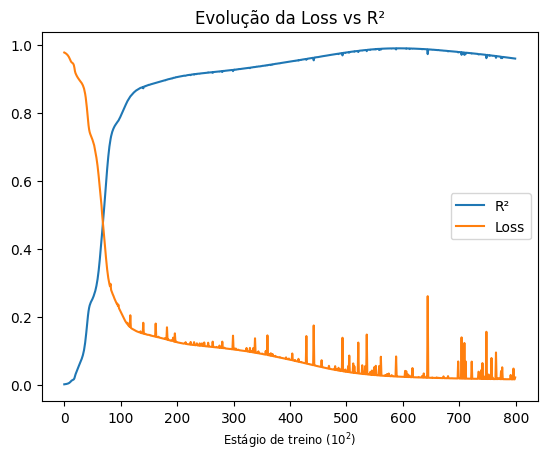

In [14]:
fig11 = plt.figure(11)
plt.plot(mse_cc_history, label = "MSE")
plt.plot(loss_cc_history, label = "Loss")
plt.title("Evolução da Loss vs MSE")
plt.xlabel("Estágio de treino ($10^2$)", fontsize = "small")
plt.yscale("log")
plt.legend()

fig12 = plt.figure(12)
plt.plot(mae_cc_history, label = "MAE")
plt.plot(loss_cc_history, label = "Loss")
plt.title("Evolução da Loss vs MAE")
plt.xlabel("Estágio de treino ($10^2$)", fontsize = "small")
plt.yscale("log")
plt.legend()

fig13 = plt.figure(13)
plt.plot(r2_cc_history, label = "R²")
plt.plot(loss_cc_history, label = "Loss")
plt.title("Evolução da Loss vs R²")
plt.xlabel("Estágio de treino ($10^2$)", fontsize = "small")
plt.legend()

Nas 3 métricas observadas há um decaimento dos erros associados à solução encontrada pela rede neural. O fator $R^2$ tende a $1$ à medida que o número de épocas aumenta, logo, há uma boa convergência do modelo para a solução exata conhecida. Já a precisão associada aos erros é da ordem de $0.1$.

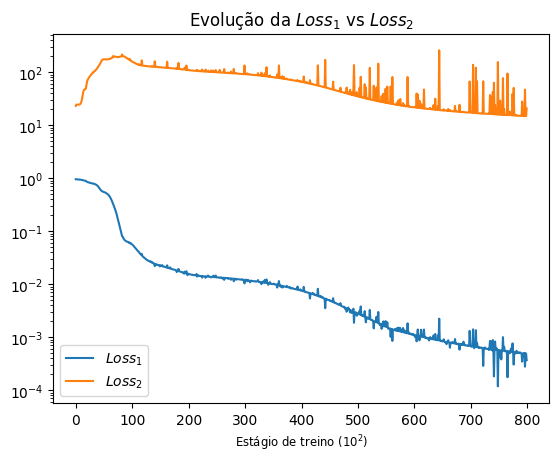

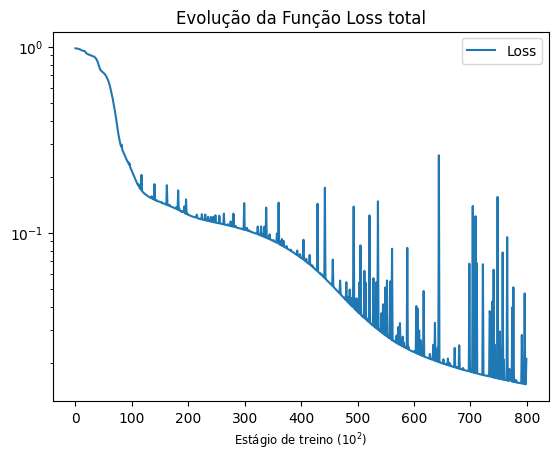

In [15]:
fig14 = plt.figure(14)
plt.plot(loss1_cc_history, label = "$Loss_1$")
plt.plot(loss2_cc_history, label = "$Loss_2$")
plt.title("Evolução da $Loss_1$ vs $Loss_2$")
plt.xlabel("Estágio de treino ($10^2$)", fontsize = "small")
plt.yscale("log")
plt.legend()

fig15 = plt.figure(15)
plt.plot(loss_cc_history, label = "Loss")
plt.title("Evolução da Função Loss total")
plt.xlabel("Estágio de treino ($10^2$)", fontsize = "small")
plt.yscale("log")
plt.legend()

Observe o decaimento da Função Loss e seu comportamento com o aumento do número de épocas. Nesse sentido, notamos que, tendo dado um peso maior à Loss$_{1}$ associada à condição de contorno, durante o treino a rede neural vai dar mais importância a encontrar uma solução que passe pelo único ponto fornecido, mais do que uma solução que, de fato, satisfaça a EDO.

# **Outros testes**

**Caso:** Loss$_{2}$ com peso 1.001e-3

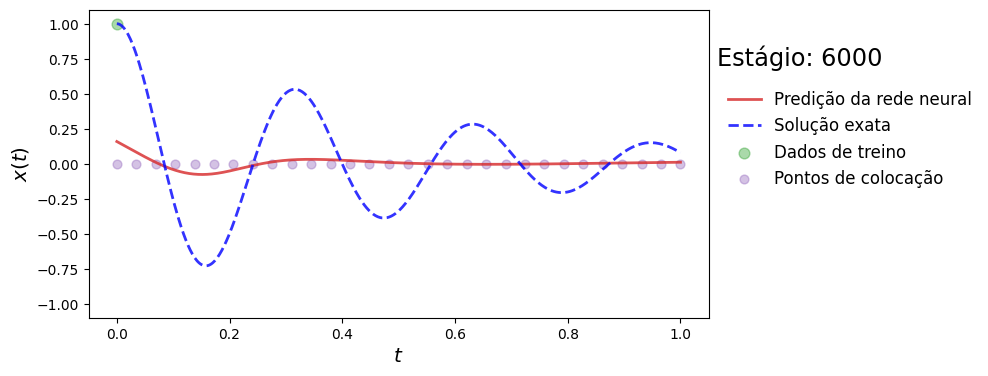

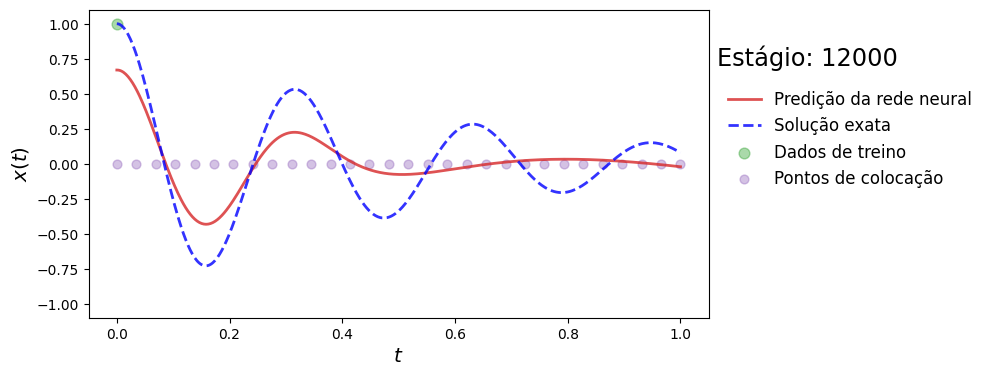

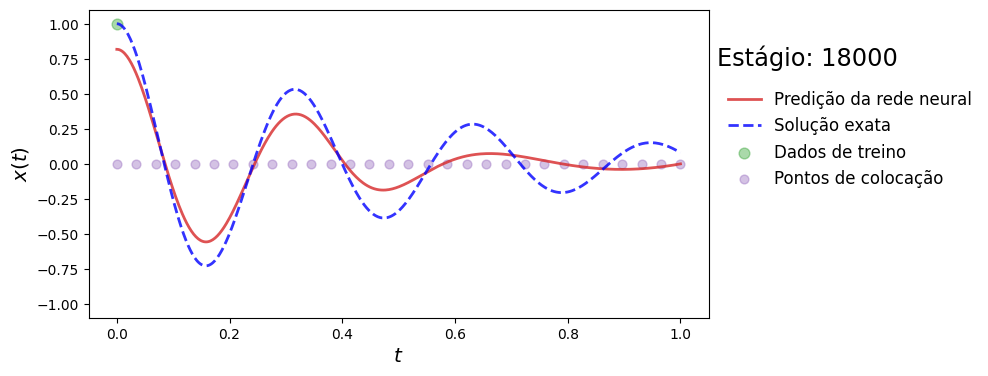

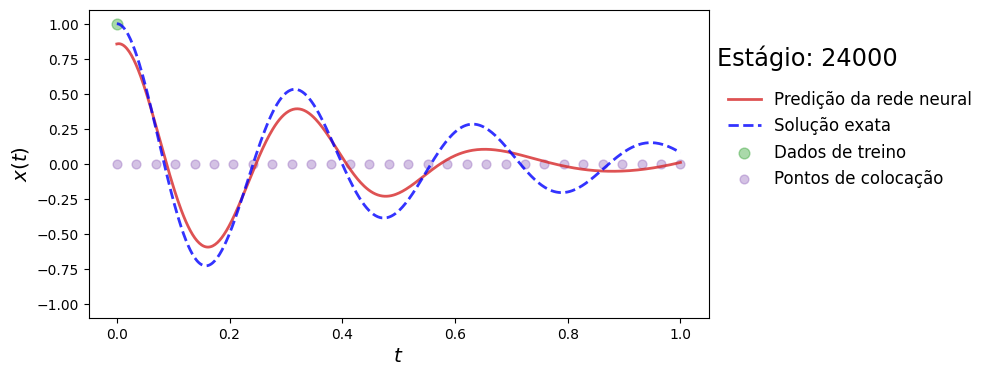

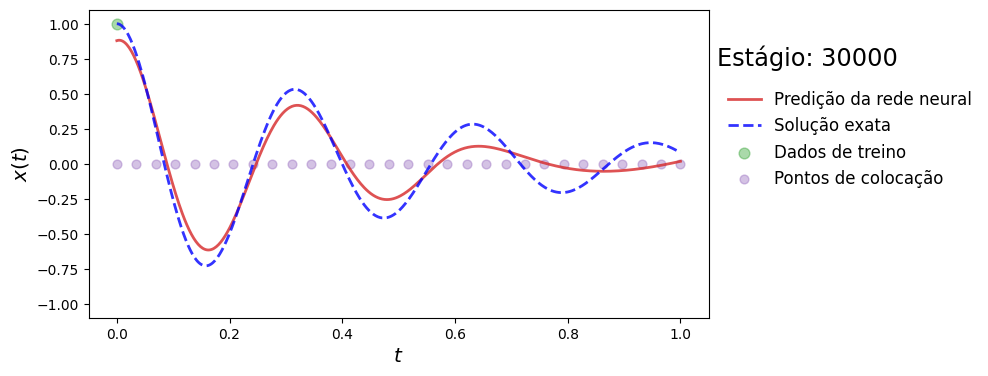

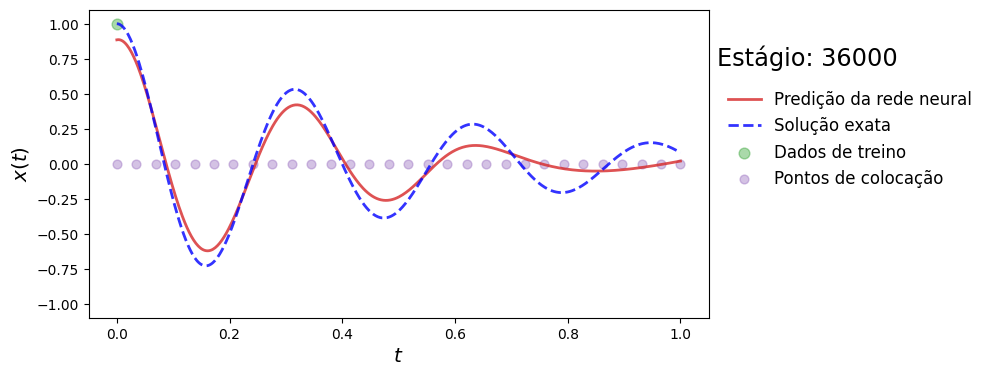

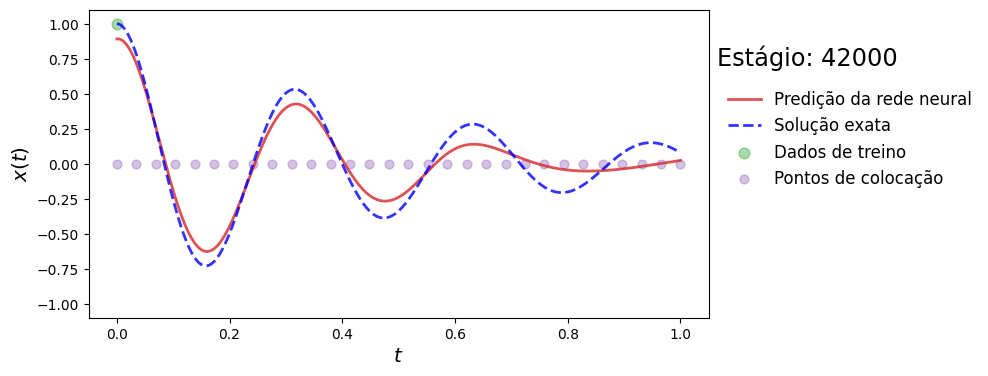

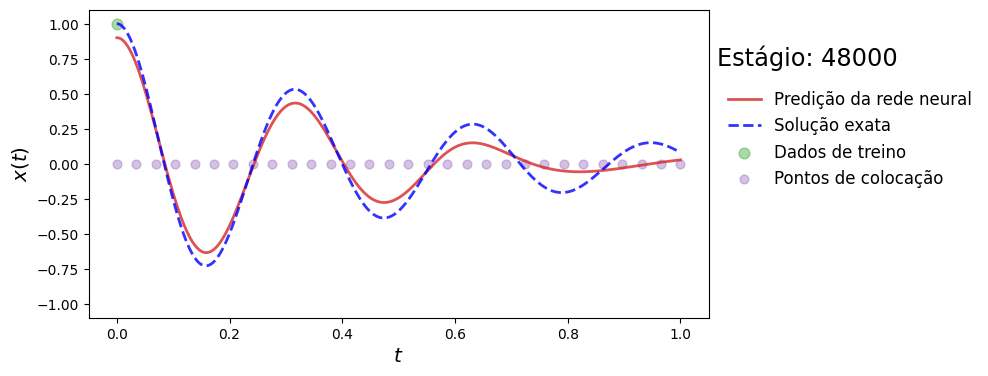

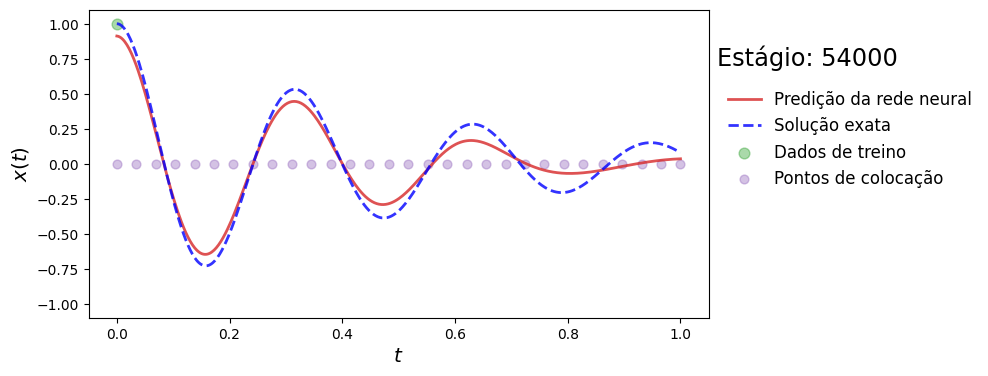

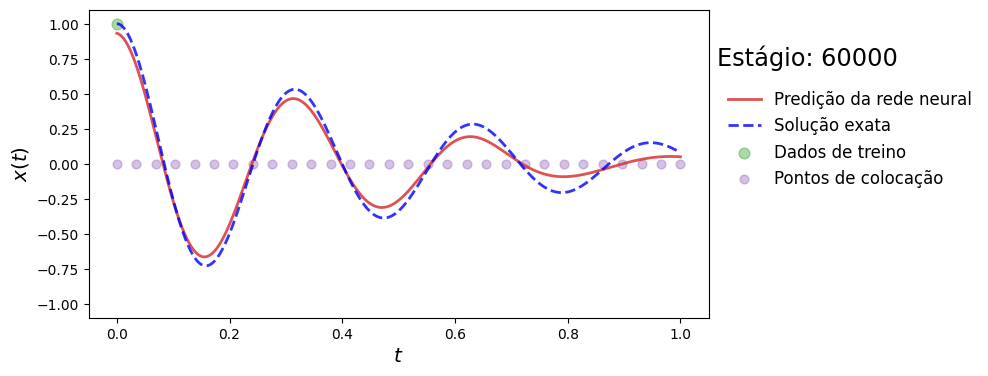

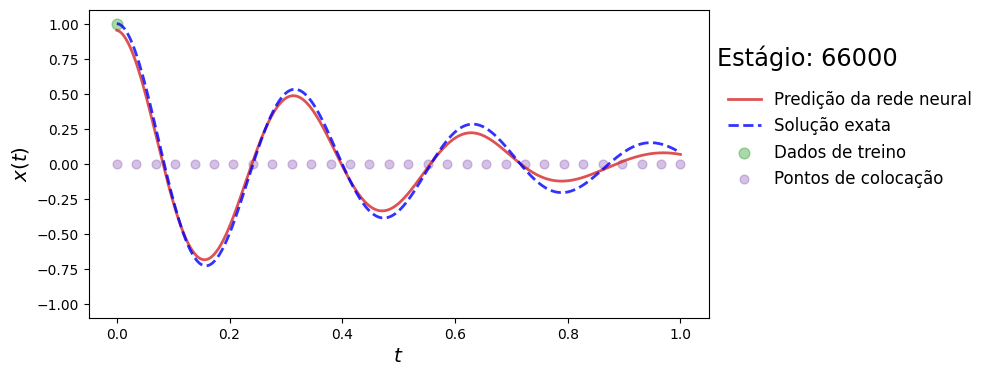

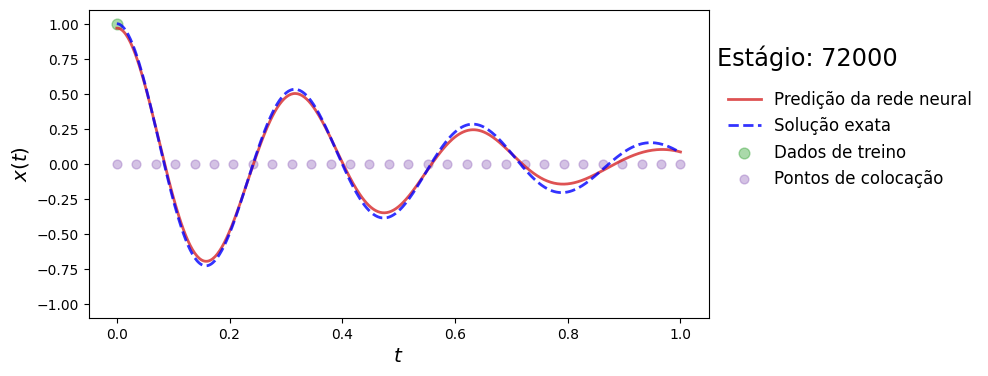

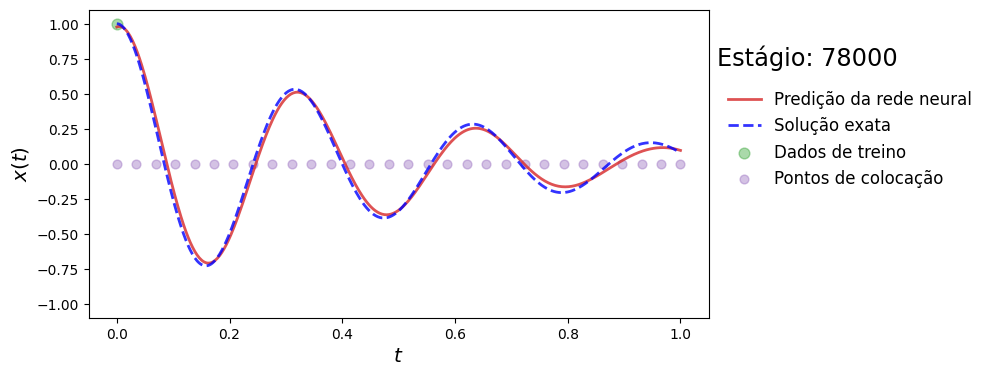

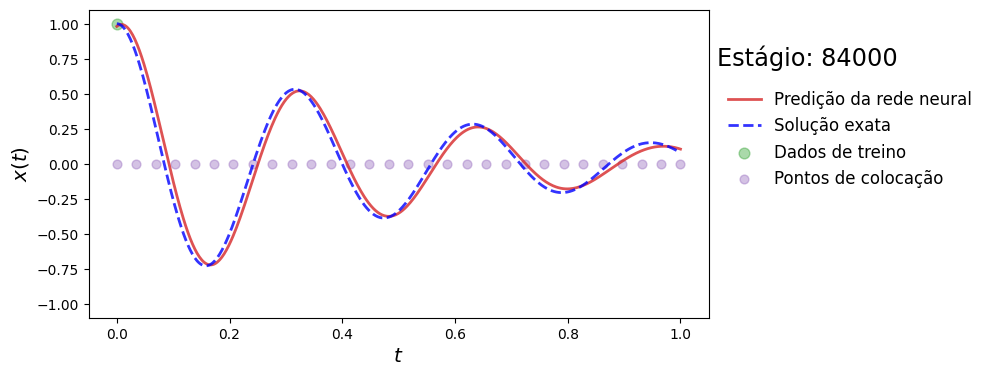

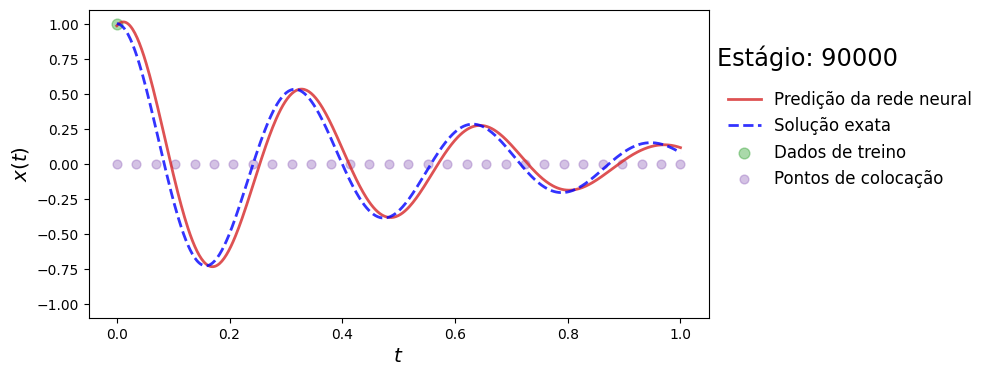

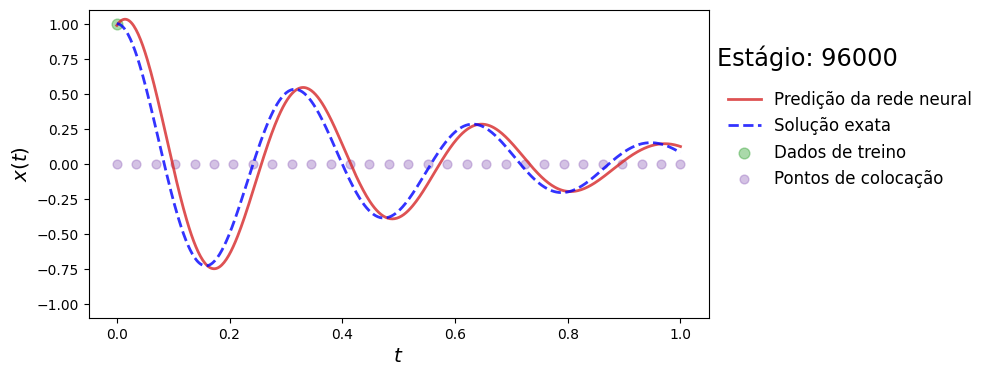

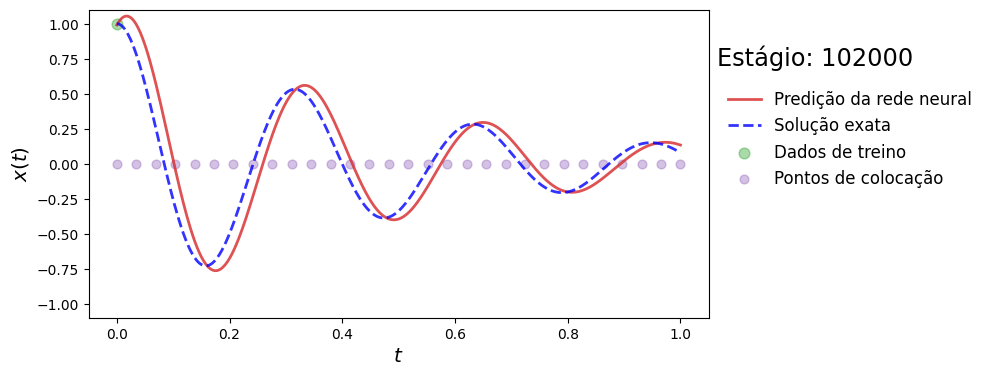

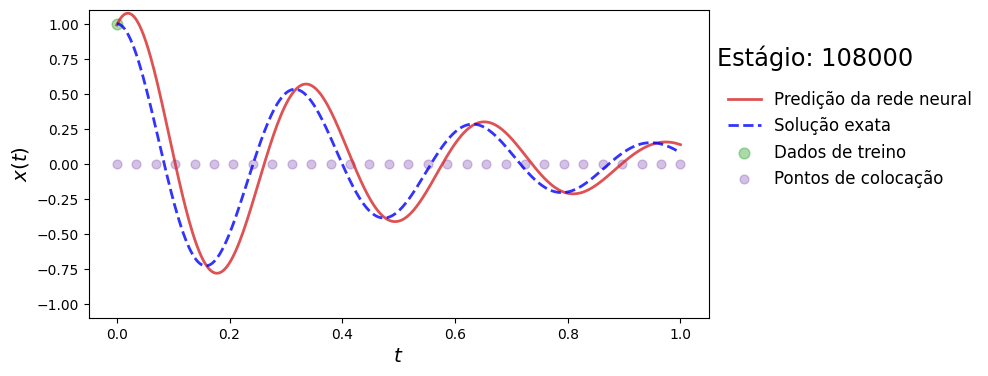

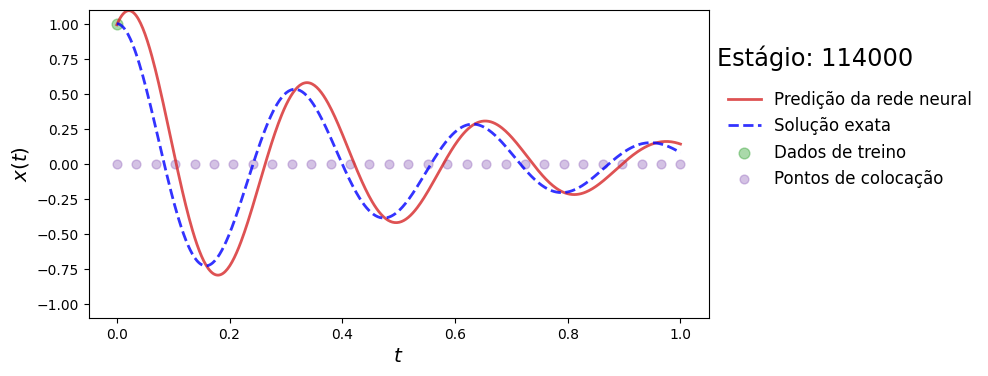

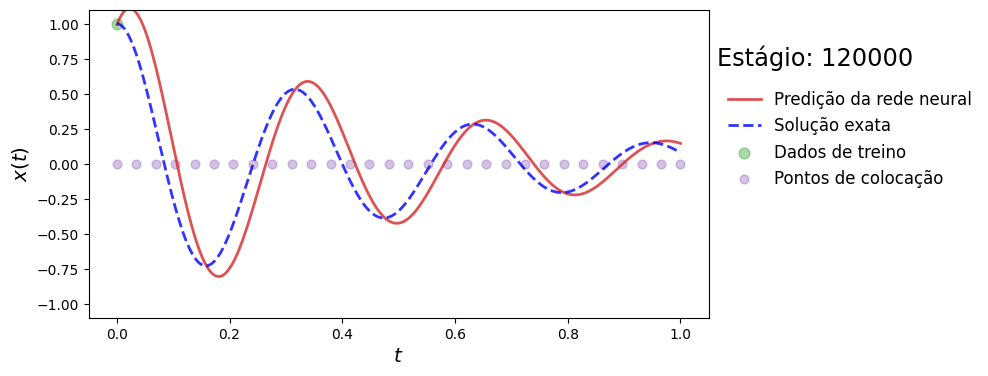

In [16]:
# determina o conjunto de pontos de colocação no domínio físico

t_physics_cc = torch.linspace(0, 1, 30).view(-1,1).requires_grad_(True)
mu, k = 2*d, w0**2

# configuração do treino da PINN

torch.manual_seed(7)
model = FCN(1, 1, 42, 4)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
files = []
loss1_cc_history = []
loss2_cc_history = []
loss_cc_history = []
mse_cc_history = []
mae_cc_history = []
r2_cc_history = []

# loop de treino

for i in range(120000):
    optimizer.zero_grad()

    # calcula o "data loss"

    x_pred_cc = model(t_cc)
    loss1_cc = torch.mean((x_pred_cc - x_cc)**2)

    # calcula a "physics loss"

    x_pred_p_cc = model(t_physics_cc)

    # calcula o resíduo

    dt_cc  = torch.autograd.grad(x_pred_p_cc, t_physics_cc, torch.ones_like(x_pred_p_cc), create_graph = True)[0]       # dy/dt
    dt2_cc = torch.autograd.grad(dt_cc,  t_physics_cc, torch.ones_like(dt_cc),  create_graph = True)[0]          # d^2y/dt^2
    physics_cc = dt2_cc + mu*dt_cc + k*x_pred_p_cc

    loss2_cc = torch.mean(physics_cc**2)

    # backpropagate joint loss

    loss_cc = loss1_cc + (1.001e-3)*loss2_cc
    loss_cc.backward()
    optimizer.step()

    # grafica o resultado dos estágios do treino

    if (i+1) % 150 == 0:
        loss1_cc_history.append(loss1_cc.detach())
        loss2_cc_history.append(loss2_cc.detach())
        loss_cc_history.append(loss_cc.detach())

        x_pred_cc = model(t).detach()
        t_pred_cc = t_physics_cc.detach()

        x_pred_p_cc = model(t)

        mse_cc = torch.mean((x_pred_p_cc - x)**2)  # erro quadrático médio
        mse_cc_history.append(mse_cc.detach())

        mae_cc = torch.mean(torch.abs(x_pred_p_cc - x))  # erro absoluto médio
        mae_cc_history.append(mae_cc.detach())

        res_cc = torch.sum((x_pred_p_cc - x)**2)
        tot_cc = torch.sum((torch.mean(x) - x)**2)
        r2_cc = 1 - res_cc/tot_cc                    # fator R^2
        r2_cc_history.append(r2_cc.detach())

        plot_result(t, x, t_cc, x_cc, x_pred_cc, t_pred_cc)

        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")

Mesmo alterando um pouco o peso da Loss$_{2}$ notamos que há um delay entre a solução exata e a solução prevista pela rede neural.